<h1 div class='alert alert-success'><center> Tunning Hyperparameters XGB
 </center></h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

# <div class="alert alert-success">  0. IMPORTAÇÕES </div>

In [1]:
!pip install --q optuna
!pip install --q GPUtil
!pip install --q Boruta

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 81 kB 10.7 MB/s 
     |████████████████████████████████| 210 kB 97.5 MB/s 
     |████████████████████████████████| 75 kB 5.8 MB/s 
     |████████████████████████████████| 150 kB 90.6 MB/s 
     |████████████████████████████████| 49 kB 7.9 MB/s 
     |████████████████████████████████| 113 kB 90.7 MB/s 
     |████████████████████████████████| 56 kB 2.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 0.1. Bibliotecas

In [3]:
import warnings
import os
import gc
import random
import glob
import optuna
import re
import sklearn.exceptions

In [4]:
import pandas               as pd
import numpy                as np
import matplotlib.pyplot    as plt 
import seaborn              as sns
import joblib               as jb

In [5]:
import torch
import torch.nn             as nn

In [6]:
import xgboost              as xgb

In [7]:
from sklearn.model_selection       import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing         import QuantileTransformer, StandardScaler
from sklearn.preprocessing         import RobustScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder
from sklearn                       import metrics
from sklearn.feature_selection     import SelectKBest, SelectPercentile, f_classif

In [8]:
from optuna.samplers               import TPESampler
from optuna.visualization          import plot_edf
from optuna.visualization          import plot_optimization_history
from optuna.visualization          import plot_parallel_coordinate
from optuna.visualization          import plot_param_importances
from optuna.visualization          import plot_slice
from optuna.visualization          import plot_intermediate_values
from optuna.visualization          import plot_contour
from optuna.pruners                import MedianPruner
from optuna.pruners                import BasePruner
from optuna.trial._state           import TrialState

In [9]:
from GPUtil                        import showUtilization as gpu_usage
from numba                         import cuda
from sklearn.ensemble              import IsolationForest
from psutil                        import virtual_memory
from datetime                      import datetime
from psutil                        import virtual_memory
from sklearn.utils.class_weight    import compute_sample_weight
from boruta                        import BorutaPy
from multiprocessing               import cpu_count
from scipy.stats                   import pearsonr

## 0.2. Funções

In [10]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

    pd.set_option('display.max_rows', 200)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]
    
    # Colors
    dark_red   = "#b20710"
    black      = "#221f1f"
    green      = "#009473"
    myred      = '#CD5C5C'
    myblue     = '#6495ED'
    mygreen    = '#90EE90'    
    color_cols = [myred, myblue,mygreen]
    
    return icecream, colors, color_cols

icecream, colors, color_cols = jupyter_setting()

In [11]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [12]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.rcParams['font.size'] = 12
    plt.title('Precision Recall vs threshold')
    plt.xlabel('Threshold')
    plt.legend(loc="lower left")
    
    plt.grid(True)

In [13]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b-", label="Precision")
    
    plt.rcParams['font.size'] = 12
    plt.title('Precision vs recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # plt.legend(loc="lower left")
    
    plt.grid(True)

In [14]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('XGBR ROC curve for TPS 09')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

In [15]:
def graf_feature_corr(df, annot_=False, threshold=.8, print_var=False):
    
    df = df.corr(method ='pearson').round(5)

    # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True

    # Making a plot
    plt.figure(figsize=(20,12))
    ax = sns.heatmap(df, annot=annot_, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})

    ax.set_title("Mapa de calor de correlação das variável", fontsize=17)

    plt.setp(ax.get_xticklabels(), 
             rotation      = 90, 
             ha            = "right",
             rotation_mode = "anchor", 
             weight        = "normal")

    plt.setp(ax.get_yticklabels(), 
             weight        = "normal",
             rotation_mode = "anchor", 
             rotation      = 0, 
             ha            = "right");
    
    if print_var: 
        print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold))
        df_corr = df[abs(df)>threshold][df!=1.0].unstack().dropna().reset_index()
        df_corr.columns =  ['var_1', 'var_2', 'corr']
        display(df_corr)


In [16]:
def correlation(dataset, threshold):

    col_corr    = set()  # Conjunto de todos os nomes de colunas correlacionadas
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold: # estamos interessados no valor coeficiente absoluto
                colname = corr_matrix.columns[i]        # obtendo o nome da coluna
                col_corr.add(colname)
    
    return col_corr

In [17]:
def free_gpu_cache():
    
    # https://www.kaggle.com/getting-started/140636
    #print("Initial GPU Usage")
    #gpu_usage()                             

    #cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)   
    
    gc.collect()
    torch.cuda.empty_cache()

In [18]:
def diff(t_a, t_b):
    from dateutil.relativedelta import relativedelta
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [19]:
def describe(df):
    var = df.columns

    # Medidas de tendência central, média e mediana 
    ct1 = pd.DataFrame(df[var].apply(np.mean)).T
    ct2 = pd.DataFrame(df[var].apply(np.median)).T

    # Dispensão - str, min , max range skew, kurtosis
    d1 = pd.DataFrame(df[var].apply(np.std)).T
    d2 = pd.DataFrame(df[var].apply(min)).T
    d3 = pd.DataFrame(df[var].apply(max)).T
    d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

    # concatenete 
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
    m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
    
    return m

In [20]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for TPS 09')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

In [21]:
def confusion_plot(matrix, labels = None, title = None):
        
    labels = labels if labels else ['Negative (0)', 'Positive (1)']    
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    sns.heatmap(data        = matrix, 
                cmap        = 'Blues', 
                annot       = True, 
                fmt         = 'd',
                xticklabels = labels, 
                yticklabels = labels, 
                ax          = ax);
    
    ax.set_xlabel('\n PREVISTO', fontsize=15)
    ax.set_ylabel('REAL \n', fontsize=15)
    ax.set_title(title)
    
    plt.close();
    
    return fig;

In [22]:
def graf_outlier(df, feature):
    col = [(0,4), (5,9)]

    df_plot = ((df[feature] - df[feature].min())/
               (df[feature].max() - df[feature].min()))

    fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

    for i, (x) in enumerate(col): 
        sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

In [23]:
def graf_eval():

    results     = model.evals_result()
    ntree_limit = model.best_ntree_limit

    plt.figure(figsize=(20,7))

    for i, error in  enumerate(['mlogloss', 'merror']):#
        
        plt.subplot(1,2,i+1)
        plt.plot(results["validation_0"][error], label="Treinamento")
        plt.plot(results["validation_1"][error], label="Validação")

        plt.axvline(ntree_limit, 
                    color="gray", 
                    label="N. de árvore ideal {}".format(ntree_limit))
                    
        
        title_name ='\n' + error.upper() + ' PLOT \n'
        plt.title(title_name)
        plt.xlabel("Número de árvores")
        plt.ylabel(error)
        plt.legend();

## 0.3. GPU

### 0.3.1. Informações

In [24]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Feb 26 20:21:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 0.3.2. Memória

In [25]:
ram_gb = virtual_memory().total / 1e9

print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## 0.4. Dados

### 4.1. Estrutura de diretório

In [26]:
paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'model', 
         'model/preds', 'model/optuna','model/preds/test', 'model/mdl/',
         'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
         'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
         'model/preds/train/n3', 'model/preds/param',  
         'Data/submission/tunning/']

for path in paths:
    try:
        os.mkdir(path)       
    except:
        pass   

In [27]:
path      = '/content/drive/MyDrive/kaggle/Tabular Playground Series/2022/02 - Fevereiro/'
#path      = '../input/tabular-playground-series-feb-2022/'
#path      = 'Data/'
path_data = 'Data/'  
path_pkl  = 'pkl/' #'../input/tps-feb-01-22/'
path_sub  = 'Data/' #'../input/tabular-playground-series-feb-2022/'
target    = 'target'

### 4.2. Carregar Datasets

In [28]:
df3_train     = jb.load(path + path_data + path_pkl + 'df2_nb_02_train.pkl.z')
df3_test      = jb.load(path + path_data + path_pkl + 'df2_nb_02_test.pkl.z')
df_submission = pd.read_csv(path + path_sub + 'sample_submission.csv')

df3_train.shape, df3_test.shape

((123993, 318), (100000, 316))

In [29]:
df3_train.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,A0T0G10C0,A0T1G0C9,A0T1G1C8,A0T1G2C7,A0T1G3C6,A0T1G4C5,A0T1G5C4,A0T1G6C3,A0T1G7C2,A0T1G8C1,A0T1G9C0,A0T2G0C8,A0T2G1C7,A0T2G2C6,A0T2G3C5,A0T2G4C4,A0T2G5C3,A0T2G6C2,A0T2G7C1,A0T2G8C0,A0T3G0C7,A0T3G1C6,A0T3G2C5,A0T3G3C4,A0T3G4C3,A0T3G5C2,A0T3G6C1,A0T3G7C0,A0T4G0C6,A0T4G1C5,A0T4G2C4,A0T4G3C3,A0T4G4C2,A0T4G5C1,A0T4G6C0,A0T5G0C5,A0T5G1C4,A0T5G2C3,A0T5G3C2,A0T5G4C1,A0T5G5C0,A0T6G0C4,A0T6G1C3,A0T6G2C2,A0T6G3C1,A0T6G4C0,A0T7G0C3,A0T7G1C2,A0T7G2C1,A0T7G3C0,A0T8G0C2,A0T8G1C1,A0T8G2C0,A0T9G0C1,A0T9G1C0,A0T10G0C0,A1T0G0C9,A1T0G1C8,A1T0G2C7,A1T0G3C6,A1T0G4C5,A1T0G5C4,A1T0G6C3,A1T0G7C2,A1T0G8C1,A1T0G9C0,A1T1G0C8,A1T1G1C7,A1T1G2C6,A1T1G3C5,A1T1G4C4,A1T1G5C3,A1T1G6C2,A1T1G7C1,A1T1G8C0,A1T2G0C7,A1T2G1C6,A1T2G2C5,A1T2G3C4,A1T2G4C3,A1T2G5C2,A1T2G6C1,A1T2G7C0,A1T3G0C6,A1T3G1C5,A1T3G2C4,A1T3G3C3,A1T3G4C2,A1T3G5C1,A1T3G6C0,A1T4G0C5,A1T4G1C4,A1T4G2C3,A1T4G3C2,A1T4G4C1,A1T4G5C0,A1T5G0C4,A1T5G1C3,A1T5G2C2,A1T5G3C1,A1T5G4C0,A1T6G0C3,A1T6G1C2,A1T6G2C1,A1T6G3C0,A1T7G0C2,A1T7G1C1,A1T7G2C0,A1T8G0C1,A1T8G1C0,A1T9G0C0,A2T0G0C8,A2T0G1C7,A2T0G2C6,A2T0G3C5,A2T0G4C4,A2T0G5C3,A2T0G6C2,A2T0G7C1,A2T0G8C0,A2T1G0C7,A2T1G1C6,A2T1G2C5,A2T1G3C4,A2T1G4C3,A2T1G5C2,A2T1G6C1,A2T1G7C0,A2T2G0C6,A2T2G1C5,A2T2G2C4,A2T2G3C3,A2T2G4C2,A2T2G5C1,A2T2G6C0,A2T3G0C5,A2T3G1C4,A2T3G2C3,A2T3G3C2,A2T3G4C1,A2T3G5C0,A2T4G0C4,A2T4G1C3,A2T4G2C2,A2T4G3C1,A2T4G4C0,A2T5G0C3,A2T5G1C2,A2T5G2C1,A2T5G3C0,A2T6G0C2,A2T6G1C1,A2T6G2C0,A2T7G0C1,A2T7G1C0,A2T8G0C0,A3T0G0C7,A3T0G1C6,A3T0G2C5,A3T0G3C4,A3T0G4C3,A3T0G5C2,A3T0G6C1,A3T0G7C0,A3T1G0C6,A3T1G1C5,A3T1G2C4,A3T1G3C3,A3T1G4C2,A3T1G5C1,A3T1G6C0,A3T2G0C5,A3T2G1C4,A3T2G2C3,A3T2G3C2,A3T2G4C1,A3T2G5C0,A3T3G0C4,A3T3G1C3,A3T3G2C2,A3T3G3C1,A3T3G4C0,A3T4G0C3,A3T4G1C2,A3T4G2C1,A3T4G3C0,A3T5G0C2,A3T5G1C1,A3T5G2C0,A3T6G0C1,A3T6G1C0,A3T7G0C0,A4T0G0C6,A4T0G1C5,A4T0G2C4,A4T0G3C3,A4T0G4C2,A4T0G5C1,A4T0G6C0,A4T1G0C5,A4T1G1C4,A4T1G2C3,A4T1G3C2,A4T1G4C1,A4T1G5C0,A4T2G0C4,A4T2G1C3,A4T2G2C2,A4T2G3C1,A4T2G4C0,A4T3G0C3,A4T3G1C2,A4T3G2C1,A4T3G3C0,A4T4G0C2,A4T4G1C1,A4T4G2C0,A4T5G0C1,A4T5G1C0,A4T6G0C0,A5T0G0C5,A5T0G1C4,A5T0G2C3,A5T0G3C2,A5T0G4C1,A5T0G5C0,A5T1G0C4,A5T1G1C3,A5T1G2C2,A5T1G3C1,A5T1G4C0,A5T2G0C3,A5T2G1C2,A5T2G2C1,A5T2G3C0,A5T3G0C2,A5T3G1C1,A5T3G2C0,A5T4G0C1,A5T4G1C0,A5T5G0C0,A6T0G0C4,A6T0G1C3,A6T0G2C2,A6T0G3C1,A6T0G4C0,A6T1G0C3,A6T1G1C2,A6T1G2C1,A6T1G3C0,A6T2G0C2,A6T2G1C1,A6T2G2C0,A6T3G0C1,A6T3G1C0,A6T4G0C0,A7T0G0C3,A7T0G1C2,A7T0G2C1,A7T0G3C0,A7T1G0C2,A7T1G1C1,A7T1G2C0,A7T2G0C1,A7T2G1C0,A7T3G0C0,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target,sample_weight,fe_mean,fe_std,fe_median,fe_var,fe_min,fe_max,fe_skew,fe_kurt,fe_quantile_25,fe_quantile_50,fe_quantile_75,fe_range,fe_iqr,fe_tails,fe_dispersion_1,fe_A,fe_T,fe_G,fe_C,fe_gcd,fe_pca_0,fe_pca_1,fe_pca_2,fe_pca_3,fe_cluster_0,fe_cluster_1,fe_cluster_2,fe_cluster_3,fe_cluster_4,fe_cluster_5
0,-9.536743e-07,-0.00001,-0.000043,-0.000114,-0.0002,-0.00024,-0.0002,-0.000114,-0.000043,-0.00001,-9.536743e-07,-0.00001,-0.000086,-0.000343,-0.000801,-0.001202,-0.001202,-0.000801,-0.000343,-0.000086,-0.00001,-0.000043,-0.000343,-0.001202,0.007595,-0.003004,-0.002403,0.008797,-0.000343,-0.000043,-0.000114,-0.000801,-0.002403,-0.004005,0.005993,-0.002403,-0.000801,-0.000114,-0.0002,-0.001202,-0.003004,-0.004005,-0.003004,-0.001202,-0.0002,-0.00024,-0.001202,-0.002403,-0.002403,0.008797,-0.00024,-0.0002,-0.000801,-0.001202,-0.000801,-0.0002,-0.000114,-0.000343,-0.000343,-0.000114,-0.000043,-0.000086,-0.000043,-0.000010,-0.00001,-9.536743e-07,-0.00001,-0.000086,-0.000343,-0.000801,0.008797,-0.001202,-0.000801,-0.000343,-0.000086,-0.00001,-0.000086,-0.000687,-0.002403,0.005192,0.013992,0.015190,-0.002403,-0.000687,-0.000086,-0.000343,-0.002403,0.012787,0.007980,0.017990,0.002790,-0.002403,-0.000343,-0.000801,-0.004807,-0.002016,-0.006023,-0.002016,-0.004807,0.009201,-0.001202,0.003990,-0.012016,-0.002016,-0.006008,-0.001202,-0.001202,0.015190,0.002790,-0.004807,0.008797,-0.000801,-0.002403,-0.002

In [30]:
df3_train = reduce_memory_usage(df3_train)
df3_test  = reduce_memory_usage(df3_test)

Mem. usage decreased to 74.97 Mb (0.0% reduction)
Mem. usage decreased to 59.60 Mb (0.0% reduction)


# <div class="alert alert-success"> 1.  Modelagem </div>

## 1.1. Funções

In [43]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_, score_, seed_, level_='1', target_='target'):    
    
    level = 'n' + level_ + '/'

    if score_>.6:    
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)

In [44]:
def model_train_cv_fit(model_, X_, y_, X_test_, target_, model_name_, sc_=MinMaxScaler(), 
                       sc_second_=None, n_splits_=5, seed_=12359, save_sub_=True, 
                       path_='', save_predict_=False, level_='1'):
    
    taco              = 52 
    y_preds_test      = []
    y_preds_val_prob  = [] 
    y_preds_test_prob = []
    score             = []
    mdl               = []
    lb                = LabelEncoder()
    y_                = pd.DataFrame(lb.fit_transform(y_), columns=[target_])
    col_prob          = y_[target_].sort_values().unique()
    df_preds_prob     = pd.DataFrame()
    df_feature_imp    = pd.DataFrame()
    time_start        = datetime.now()    
    n_estimators      = model_.get_params()['n_estimators']
    dub_scaler        = '=> Double Scaler' if sc_second_!=None else ''
    
    print('='*taco)
    print('Scaler: {} - n_estimators: {} {}'.format(sc, n_estimators, dub_scaler))
    print('='*taco)

    folds = StratifiedKFold(n_splits=n_splits_, shuffle=True, random_state=seed_)

    for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_, groups=y)): 
        
        time_fold_start = datetime.now()
        
        # ----------------------------------------------------
        # Separar dados para treino 
        # ----------------------------------------------------
        X_trn, X_val, sample_weight_train = X_.iloc[trn_idx], X_.iloc[val_idx], X_.iloc[trn_idx]['sample_weight']
        y_trn, y_val, sample_weight_valid = y_.iloc[trn_idx], y_.iloc[val_idx], X_.iloc[val_idx]['sample_weight'] 
                
        # ----------------------------------------------------
        # Processamento
        # ----------------------------------------------------        
        X_trn.drop('sample_weight', axis=1, inplace=True)
        X_val.drop('sample_weight', axis=1, inplace=True)
        
        X_trn = pd.DataFrame(sc_.fit_transform(X_trn), columns=X_trn.columns)
        X_val = pd.DataFrame(sc_.transform(X_val), columns=X_val.columns)
        X_tst = pd.DataFrame(sc_.transform(X_test_), columns=X_test_.columns)

        if sc_second_ is not None: 
            X_trn = pd.DataFrame(sc_second_.fit_transform(X_trn), columns=X_trn.columns)
            X_val = pd.DataFrame(sc_second_.transform(X_val), columns=X_val.columns)
            X_tst = pd.DataFrame(sc_second_.transform(X_tst), columns=X_tst.columns)
                        
        # ---------------------------------------------------- 
        # Treinar o modelo 
        # ----------------------------------------------------     
        model_.fit(X_trn, 
                   y_trn,
                   sample_weight_train,
                   eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                   early_stopping_rounds = int(n_estimators*.1),
                   verbose               = False)

        # ---------------------------------------------------- 
        # Predição 
        # ----------------------------------------------------     
        #y_pred_val       = model_.predict(X_val, ntree_limit=model_.best_ntree_limit)    
        y_pred_val_prob  = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit) 
        y_pred_test_prob = model_.predict_proba(X_tst, ntree_limit=model_.best_ntree_limit)
        
        y_pred_val_prob += np.array([0, 0, 0.03, 0.036, 0, 0, 0, 0, 0, 0])         
        y_pred_val       = np.argmax(y_pred_val_prob, axis=1)
        
        y_preds_test.append(model_.predict(X_tst))
        y_preds_test_prob.append(y_pred_test_prob)
       
        df_prob_temp    = pd.DataFrame(y_pred_val_prob, columns=col_prob)
        y_pred_pbro_max = df_prob_temp.max(axis=1)

        df_prob_temp['fold']    = fold+1
        df_prob_temp['id']      = val_idx        
        df_prob_temp['y_val']   = y_val.values        
        df_prob_temp['y_pred']  = y_pred_val
        df_prob_temp['y_proba'] = np.max(y_pred_val_prob, axis=1)
                
        df_preds_prob = pd.concat([df_preds_prob, df_prob_temp], axis=0)
        
        # ---------------------------------------------------- 
        # Score 
        # ---------------------------------------------------- 
        acc = metrics.accuracy_score(y_val, y_pred_val, sample_weight=sample_weight_valid)
        score.append(acc)     

        # ---------------------------------------------------- 
        # Print resultado  
        # ---------------------------------------------------- 
        time_fold_end = diff(time_fold_start, datetime.now())        
        msg = '[Fold {}] ACC: {:2.5f} -  {}'
        print(msg.format(fold+1, acc, time_fold_end))

        # ---------------------------------------------------- 
        # Feature Importance
        # ----------------------------------------------------             
        feat_imp = pd.DataFrame(index   = X_trn.columns,
                                data    = model_.feature_importances_,                            
                                columns = ['fold_{}'.format(fold+1)])

        feat_imp['acc_'+str(fold+1)] = acc
        df_feature_imp = pd.concat([df_feature_imp, feat_imp], axis=1)

        # ---------------------------------------------------- 
        # Salvar o modelo 
        # ---------------------------------------------------- 
        dic_model = {'scaler': sc, 'scaler_second': sc_second_,'fold': fold+1,'model': model_}
        mdl.append(dic_model)

        time_end = diff(time_start, datetime.now())   

    acc_mean = np.mean(score) 
    acc_std  = np.std(score)

    df_preds_prob.sort_values("id", axis=0, ascending=True, inplace=True)

    # ------------------------------
    # Pós-processamento
    # referencia: https://www.kaggle.com/ambrosm/tpsfeb22-02-postprocessing-against-the-mutants
    # -------------------------------        
    y_proba  = sum(y_preds_test_prob) / len(y_preds_test_prob)
    y_proba += np.array([0, 0, 0.03, 0.036, 0, 0, 0, 0, 0, 0])  
    
    y_pred_tuned      = lb.inverse_transform(np.argmax(y_proba, axis=1))
    y_pred_tuned_prob = np.max(y_proba, axis=1)

    if save_predict_:                 
        save_data_model(model_             = mdl, 
                        model_name_        = model_name_ +'_'+str(sc_second_).lower()[:4], 
                        path_              = path_, 
                        y_pred_train_prob_ = df_preds_prob['y_proba'], 
                        y_pred_test_prob_  = y_pred_tuned_prob, 
                        y_pred_test_       = y_pred_tuned,
                        score_             = acc_mean, 
                        seed_              = seed_, 
                        level_             = level_, 
                        target_            = target_
                        ) 

    print('-'*taco)
    print('[Mean Fold] ACC: {:2.5f} std: {:2.5f} - {}'.format(acc_mean, acc_std, time_end))    
    print('='*taco)
    print()

    if save_sub_:         
        df_submission[target_] = y_pred_tuned        
        name_file_sub          = model_name_ +'_'+str(sc_second_).lower()[:4]+'.csv'
        df_submission.to_csv(path_+'Data/submission/'+name_file_sub.format(acc_mean), index=False)
        
    del X_trn, X_val, y_trn, y_val, feat_imp

    return mdl, df_feature_imp, df_feature_imp , df_preds_prob

In [45]:
def print_graf(mdl_, df_fe_imp_, eval_metric_ ):

    for erro in eval_metric_:
        plt.figure(figsize=(20,15))
        for m in range(len(mdl_)):
            row = int(len(mdl_[m])/3 + 1)
            for fold in range(len(mdl_[m])): 
                results     = mdl_[m][fold]['model'].evals_result() # merror
                ntree_limit = mdl_[m][fold]['model'].best_ntree_limit
                plt.subplot(row,3,fold+1)
                plt.plot(results["validation_0"][erro], label="Treinamento")
                plt.plot(results["validation_1"][erro], label="Validação")

                plt.axvline(ntree_limit, 
                            color="gray", 
                            label="N. de árvore ideal {}".format(ntree_limit))

                plt.xlabel("Número de árvores")
                plt.ylabel(erro)
                plt.legend();           

            plt.suptitle('Performance XGB - {}'.format(erro), y=1.05, fontsize=24);
            plt.tight_layout(h_pad=3.0); 

    for i in range(len(df_fe_imp_)):
        plt.figure(figsize=(20,15))
        row = int(np.round(df_fe_imp_[i].filter(regex=r'fold').shape[1] / 3 +1))
        for fold, col in enumerate(df_fe_imp_[i].filter(regex=r'fold').columns):            
            col_acc = 'acc_' + str(fold+1)
            df_fi = df_fe_imp_[i].sort_values(by=col, ascending=False).reset_index().iloc[:25]
            df_fi = df_fi[['index', col, col_acc]]
            df_fi.columns = ['Feature', 'score', col_acc]
            plt.subplot(row,3, fold+1)
            sns.barplot(x='score', y='Feature', data=df_fi)    
            plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
                      fontdict={'fontsize':18})    

        plt.suptitle('Feature Importance XGB - {}'.format(scaler_list[i]), y=1.05, fontsize=24);
        plt.tight_layout(h_pad=3.0); 

## 1.2. Modelo 

In [46]:
X          = df3_train.drop([target], axis=1)
y          = df3_train[target]
X_test     = df3_test

X.shape, y.shape, X_test.shape

((123993, 317), (123993,), (100000, 316))

In [47]:
#path             = ''
cols_original_tr = X.filter(regex='A[0-9]').columns.to_list()
cols_original_ts = cols_original_tr.copy()
cols_original_tr.append('sample_weight')


seed_          = 12359
mdl            = []
df_trn_mdl     = []
df_fe_imp      = []
scaler_list    = [None]
name_model_clf = 'xgb_'
name_model     = name_model_clf + 'tunning_score_01_{:2.5f}'
eval_metric    = ['merror', 'mlogloss']

<div class="alert alert-info" role="alert"> 
    
Vamos fazer um modelo com as variáveis originais, para termos uma noção do efeito das novas variáveis, neste primeiro momento defini os parametros manualmente.
       
</div>

Scaler: None - n_estimators: 1000 
[Fold 1] ACC: 0.94883 -  0h 2m 35s
[Fold 2] ACC: 0.95191 -  0h 2m 34s
[Fold 3] ACC: 0.94884 -  0h 2m 35s
[Fold 4] ACC: 0.95075 -  0h 2m 34s
[Fold 5] ACC: 0.95157 -  0h 2m 36s
----------------------------------------------------
[Mean Fold] ACC: 0.95038 std: 0.00132 - 0h 13m 5s

CPU times: user 13min 6s, sys: 5.11 s, total: 13min 11s
Wall time: 13min 8s


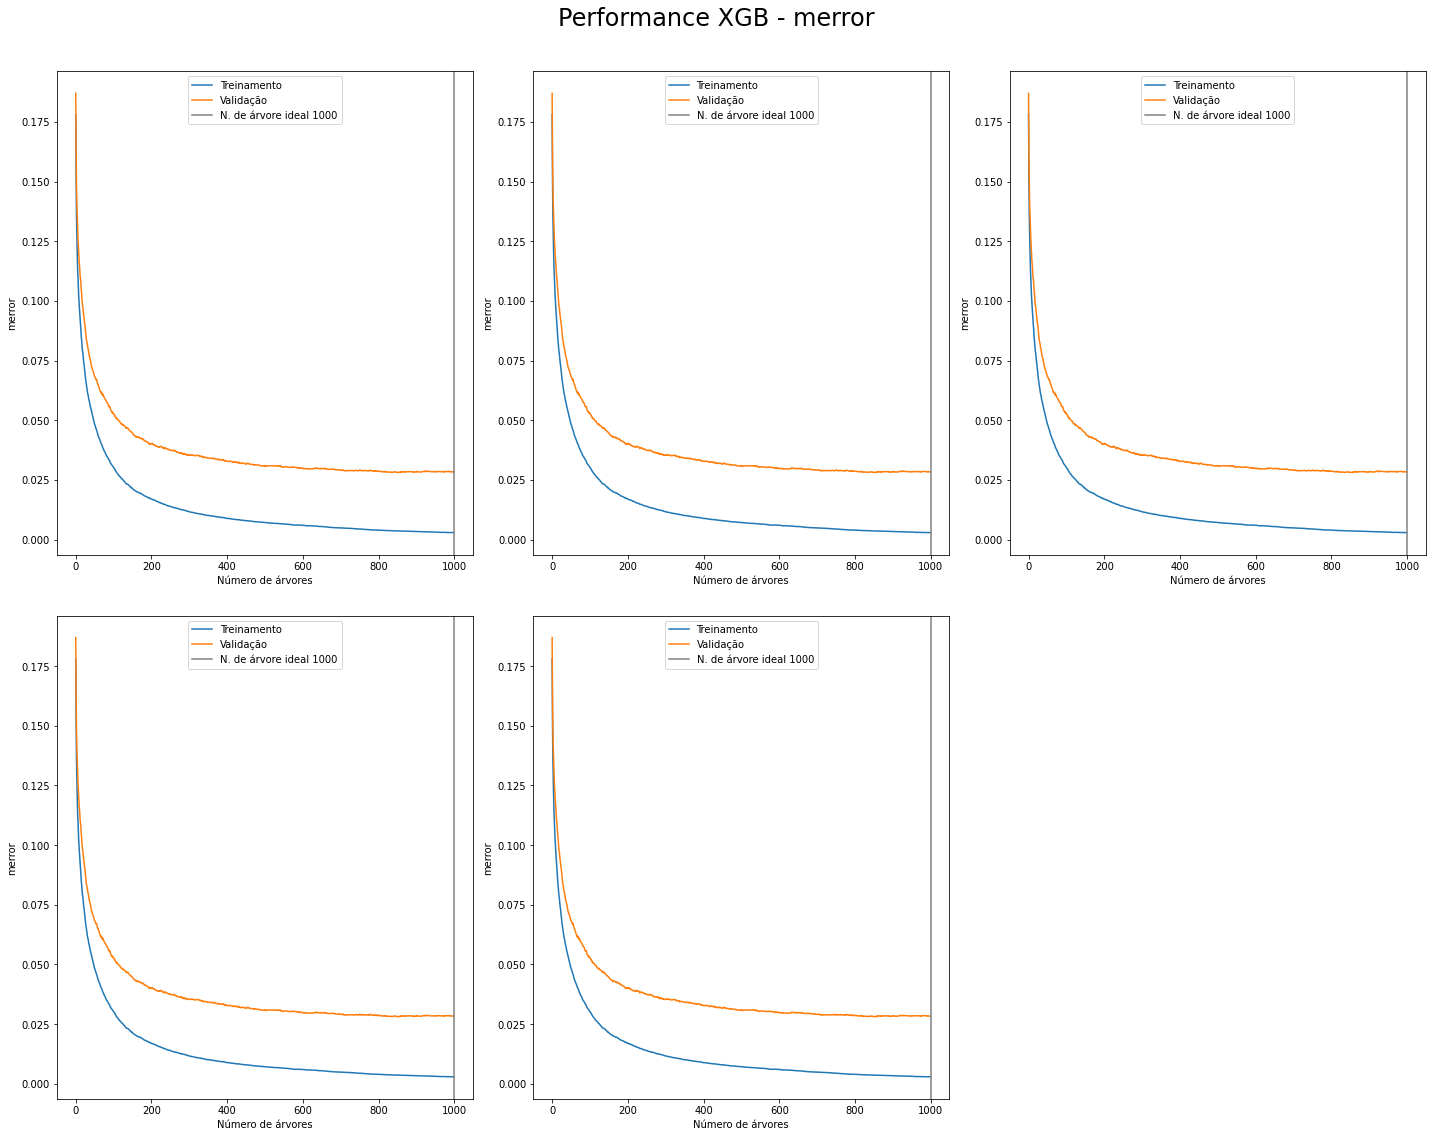

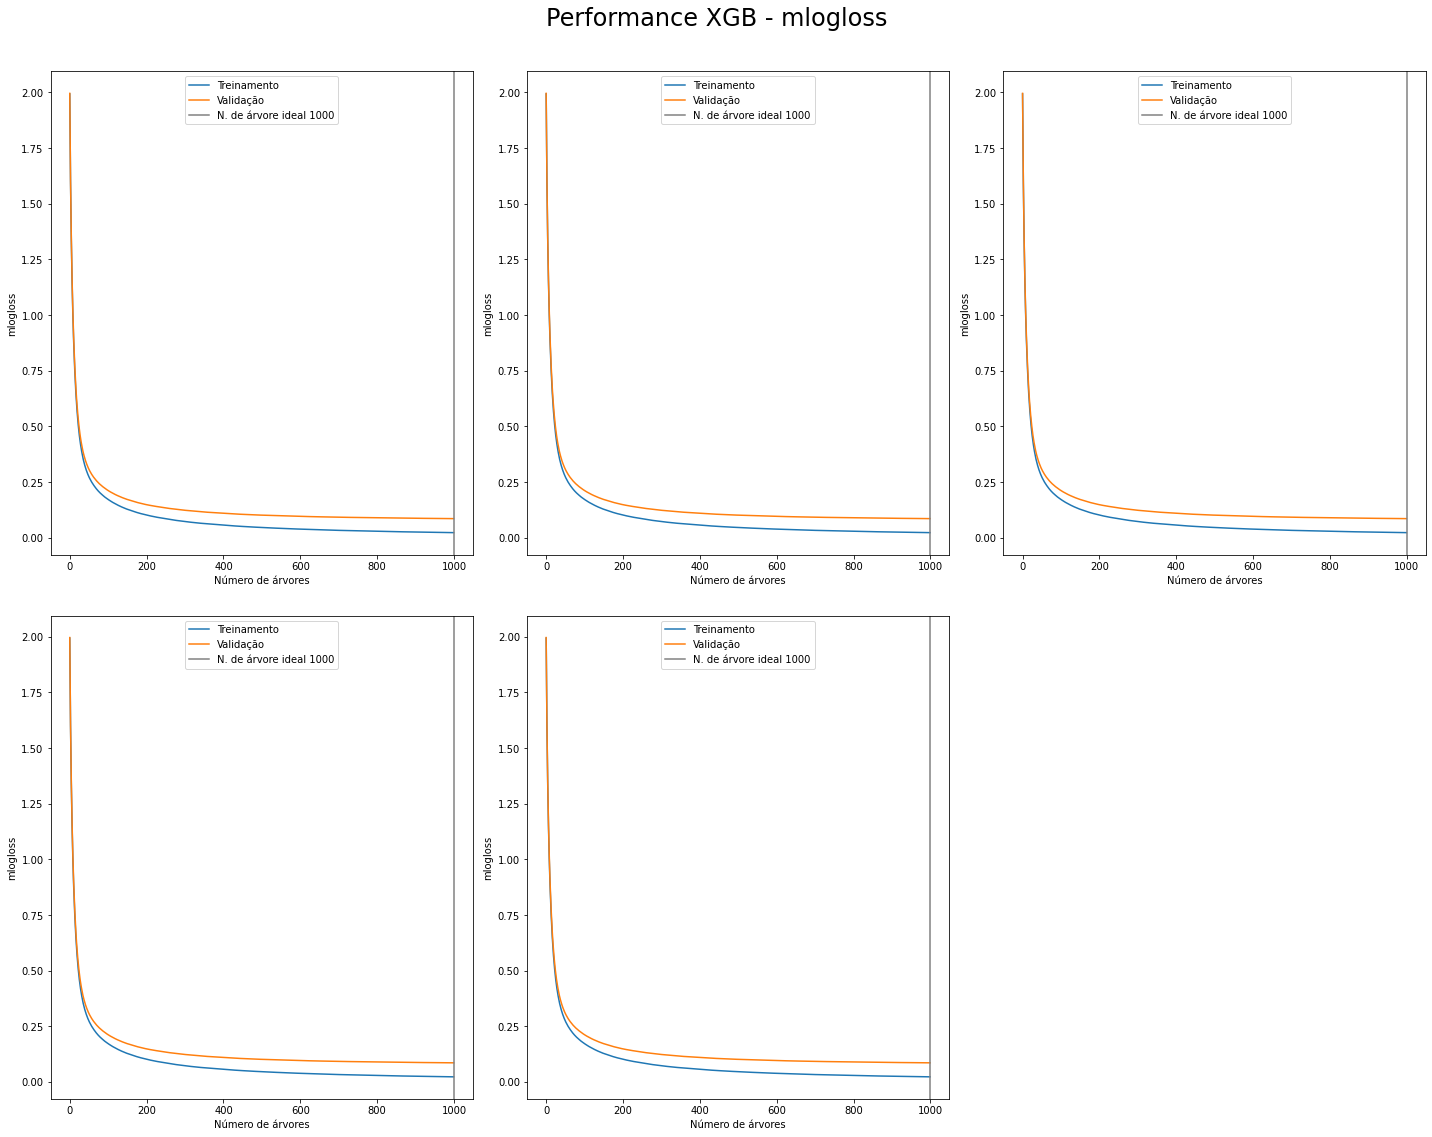

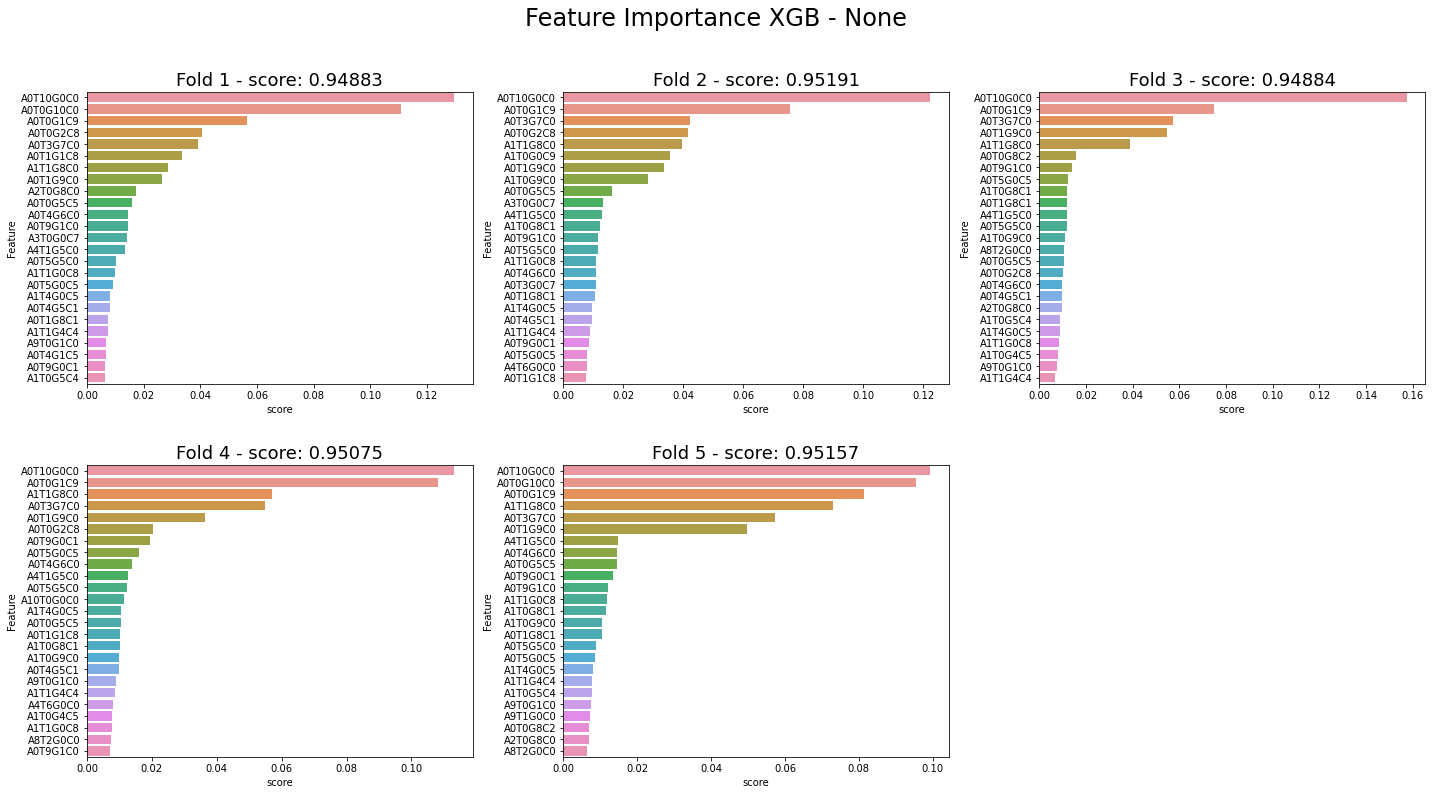

In [36]:
%%time 

params = {"objective"          : 'multi:softprob', 
          'eval_metric'        : eval_metric,
          'max_depth'          : 6, 
          'learning_rate'      : .1, 
          'subsample'          : 0.75, 
          'n_estimators'       : 1000,           
          'reg_alpha'          : 1, 
          'reg_lambda'         : 75, 
          'min_child_weight'   : 7, 
          'colsample_bytree'   : 0.85,
          'sampling_method'    : 'gradient_based',
          'booster'            : 'gbtree',
          'use_label_encoder'  : 'False', 
          'random_state'       : seed_}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})
    
for sc in scaler_list:    
    model, df_trn, df_feature_imp, df_preds_prob = \
    model_train_cv_fit(model_        = xgb.XGBClassifier(**params),
                       model_name_   = name_model,
                       X_            = X[cols_original_tr],
                       y_            = y,
                       X_test_       = X_test[cols_original_ts],                       
                       target_       = target,
                       sc_           = RobustScaler(), 
                       sc_second_    = sc,
                       n_splits_     = 5,
                       seed_         = seed_,
                       save_sub_     = True,
                       path_         = path, 
                       save_predict_ = True)

    mdl.append(model)
    df_trn_mdl.append(df_trn)
    df_fe_imp.append(df_feature_imp)

del model, df_trn, df_feature_imp

print_graf(mdl, df_fe_imp, eval_metric)

<div class="alert alert-info" role="alert"> 
Obtivemos na submissão o score de 0.93243, como podemos observar o nosso modelo tem uma performance boa, pois estamos apenas 1.83% abaixo, sendo assim, temos um baixo underfitting. 
    
<br> 
    
Agora vamos executar o mesmo modelo com todas as variáveis, isso é, com as novas variáveis criadas. 
       
</div>

In [ ]:
%%time 

seed_          = 12359
mdl            = []
df_trn_mdl     = []
df_fe_imp      = []
scaler_list    = [None]
name_model_clf = 'xgb_'
name_model     = name_model_clf + 'tunning_score_02_{:2.5f}'

eval_metric = ['merror', 'mlogloss']

params = {"objective"          : 'multi:softprob', 
          'eval_metric'        : eval_metric,
          'max_depth'          : 6, 
          'learning_rate'      : .1, 
          'subsample'          : 0.75, 
          'n_estimators'       : 1000,           
          'reg_alpha'          : 1, 
          'reg_lambda'         : 75, 
          'min_child_weight'   : 7, 
          'colsample_bytree'   : 0.85,
          'sampling_method'    : 'gradient_based',
          'booster'            : 'gbtree',  
          'use_label_encoder'  : 'False',
          'random_state'       : seed_}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})
    
for sc in scaler_list:    
    model, df_trn, df_feature_imp, df_preds_prob = \
    model_train_cv_fit(model_        = xgb.XGBClassifier(**params),
                       model_name_   = name_model,
                       X_            = X,
                       y_            = y,
                       X_test_       = X_test,                      
                       target_       = target,
                       sc_           = RobustScaler(), 
                       sc_second_    = sc,
                       n_splits_     = 5,
                       seed_         = seed_,
                       save_sub_     = True,
                       path_         = path, 
                       save_predict_ = True)

    mdl.append(model)
    df_trn_mdl.append(df_trn)
    df_fe_imp.append(df_feature_imp)

del model, df_trn, df_feature_imp
   
print_graf(mdl, df_fe_imp, eval_metric)

<div class="alert alert-info" role="alert"> 

Na submissão obtivemos o score de 0.93032 que pior que o score anterior com apenas as variáveis originais, provavelmente isso acontece porque estamos adionando ruido com as novas variávies, o ponto importante é que podemos observar na importância das variáveis que temos variáveis que foram criadas entre as 25 mais importantes, sendo assim, precisamos fazer uma filtragem das melhores variáveis, mais à frente vamos utilizar o Boruta para fazer uma filtagem das melhores variáveis.

       
</div>

# <div class="alert alert-success"> 2.  TUNNING </div>

## 2.1. Split Train/Test

In [48]:
X      = df3_train.drop([target], axis=1)
y      = pd.DataFrame(df3_train[target], columns=[target]) 
X_test = df3_test
idx_sample = X.sample(5000).index 

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      stratify     = y,
                                                      random_state = 12359)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape 

((99194, 317), (99194, 1), (24799, 317), (24799, 1))

## 2.2. Classe Tunning 

In [49]:
class LastPlacePruner(BasePruner):
    # https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/006_user_defined_pruner.html#sphx-glr-tutorial-20-recipes-006-user-defined-pruner-py    
    def __init__(self, warmup_steps, warmup_trials):
        self._warmup_steps = warmup_steps
        self._warmup_trials = warmup_trials

    def prune(self, study: "optuna.study.Study", trial: "optuna.trial.FrozenTrial") -> bool:
        # Obtenha a pontuação mais recente relatada neste teste
        step = trial.last_step

        if step:  # trial.last_step == None when no scores have been reported yet
            this_score = trial.intermediate_values[step]

            # Get scores from other trials in the study reported at the same step
            completed_trials = study.get_trials(deepcopy=False, states=(TrialState.COMPLETE,))
            other_scores = [
                t.intermediate_values[step]
                for t in completed_trials
                if step in t.intermediate_values
            ]
            other_scores = sorted(other_scores)

            # Prune if this trial at this step has a lower value than all completed trials
            # at the same step. Note that steps will begin numbering at 0 in the objective
            # function definition below.
            if step >= self._warmup_steps and len(other_scores) > self._warmup_trials:
                if this_score < other_scores[0]:
                    #print(f"prune() True: Trial {trial.number}, Step {step}, Score {this_score}")
                    return True

        return False

In [50]:
#from operator import le
class TunningModels(nn.Module):

    from sklearn.preprocessing  import StandardScaler
    from sklearn.linear_model   import RidgeClassifier
    
    def __init__(self, name_model_, X_trn_, y_trn_, X_ts_, feature_=None, 
                 seed_=12359, scaler_=StandardScaler(), feature_bin_=None, 
                 target_='target', path_='', level_='1', sc_second_= None, 
                 n_splits_=5):
        
        super(TunningModels,self).__init__() 

        self.name_clf    = name_model
        self.X_trn       = X_trn_
        self.y_trn       = y_trn_
        self.X_ts        = X_ts_         
        self.feature     = feature_
        self.seed        = seed_
        self.scaler      = scaler_
        self.feature_bin = feature_bin_ 
        self.target      = target_
        self.path        = path_
        self.level       = level_
        self.sc_second   = sc_second_
        self.n_splits    = n_splits_

    def recover_prediction_first_level():
        
        preds_train1 = glob.glob("model/train/*.pkl.z")
        preds_test   = glob.glob("model/test/*.pkl.z")
        preds_val1   = glob.glob("model/valid/*.pkl.z")

        df_train1     = []
        scores_traint = dict()

        for p_name in preds_train1:    
            p    = jb.load(p_name)
            p_df = pd.DataFrame(p, columns=[p_name.replace('model/train\\', '')])    
            df_train1.append(p_df)    
            scores_traint[p_name] = f1_score(y_train1, (p_df>.5))

        df_val1     = [] 
        scores_val1 = dict()
        for p_name in preds_val1:    
            p    = jb.load(p_name)
            p_df = pd.DataFrame(p, columns=[p_name.replace('model/valid\\', '')])    
            df_val1.append(p_df)    
            scores_val1[p_name] = f1_score(y_val1, (p_df>.5))

        df_test     = [] 
        scores_test = dict()
        for p_name in preds_test:    
            p         = jb.load(p_name)
            p_df_test = pd.DataFrame(p, columns=[p_name.replace('model/test\\', '')])    
            df_test.append(p_df_test)

        df_train1 = pd.concat(df_train1, axis=1)
        df_val1   = pd.concat(df_val1, axis=1)
        df_test   = pd.concat(df_test, axis=1)

        return df_train1, df_val1, df_test.shape
        
    def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):
                        os.remove(os.path.join(raiz, arquivo))
 
    def logging_callback(study, frozen_trail):
        prev_best = study.user_attrs.get('prev_best', None)
        if prev_best != study.best_value:
            study.set_user_attr('prev_best', study.best_value)
            print(f"Trail {frozen_trail.number} finished with best value {frozen_trail.value}")

    def df_return_preds_tunning(model_name=None, level=1, target_='target', train_shape_row=0, test_shape_row=0): 

        if level==1: 
            level_ = 'n1'
        else: 
            if level==2:
                level_ = 'n2'
            else: 
                level_ = 'n3'

        paths = ['model/preds/test/'+ level_, 'model/preds/train/' + level_ ]    

        if model_name==None: 
            model_name=''

        for i, path in enumerate(paths): 

            name_file_pkl     = glob.glob(path + '/'+ model_name + '*.pkl.z')
            dic_preds_mdl_pkl = dict()

            for p_name in name_file_pkl:    
                y_model_pkl_name_col  = p_name.replace(path + '/', '').replace('.pkl.z','') 
                y_model_pkl           = jb.load(p_name)   

                if i==0:
                    if len(y_model_pkl)==test_shape_row:
                        dic_preds_mdl_pkl[y_model_pkl_name_col] = y_model_pkl

                if i==1:
                    if len(y_model_pkl)==train_shape_row:                        
                        dic_preds_mdl_pkl[y_model_pkl_name_col] = y_model_pkl

                gc.collect()

            if i==0:         
                X_test_pred_nivel_1 = pd.DataFrame(dic_preds_mdl_pkl)
            else:
                X_train_pred_nivel_1 = pd.DataFrame(dic_preds_mdl_pkl)

            gc.collect()

        X_train_pred_nivel_1[target_] = y

        return X_train_pred_nivel_1, X_test_pred_nivel_1
    
    def feature_select(mdl, feature=[], best_score=0):
    
        best_feature = ''

        for col in df_train1.columns:

            if col not in feature:
                Xtr  = df_train1[feature+[col]].copy()
                Xval = df_val1[feature+[col]].copy()                

                mdl.fit(Xtr, y_train1)

                p = mdl.predict(Xval)
                c = f1_score(y_val1, p)

                if c > best_score:
                    best_score = c
                    best_feature = col 

        return best_score, best_feature

    def permutation_test(mdl, feature_selected):

        dist = []

        for seed in range(100):

            Xtr  = df_train1[feature_selected].copy()
            Xval = df_val1[feature_selected].copy()

            np.random.seed(seed)

            Xtr['random']  = np.random.permutation(Xtr.iloc[:, -1].values)
            Xval['random'] = np.random.permutation(Xval.iloc[:, -1].values)

            mdl.fit(Xtr, y_train1)

            p = mdl.predict(Xval)
            c = f1_score(y_val1, p)

            dist.append(c)

        dist = np.array(dist)

        return dist.max()

    def feature_selected_model(model = RidgeClassifier(alpha=1.) ):
   
        score_feature, best_feature =  TunningModels.feature_select(model)
        print('Score: {:2.4f} => Feature: {}'. format(score_feature*100 , best_feature))

        feature_selected = []
        feature_selected.append(best_feature)

        loop = True

        while loop:

            best_score = TunningModels.permutation_test(model, feature_selected) 
            best_score = best_score + 1e-4

            score_feature, best_feature = TunningModels.feature_select(model, feature=feature_selected, best_score=best_score)
            

            if score_feature <= best_score:  
                print('Fim')
                loop= False
            else: 
                feature_selected.append(best_feature)
                print('Score: {:2.4f} => Feature: {}'. format(score_feature*100 , best_feature))

        return feature_selected
    
    def model_of_diversity_feature_group(model_, name_model, X_, y_, X_ts_, sc_, target_, feature_imp_num=5, 
                                         seed_=12359, path_=''):

        TunningModels.delete_files(name_model)

        cols_tr = X_.columns.to_list() 
        cols_ts = cols_tr.copy()
        cols_ts.remove('sample_weight')

        model = model_
        model = model.fit(X_[cols_ts], y_)

        df               = pd.DataFrame()
        df["feature"]    = cols_ts
        df["importance"] = model.feature_importances_

        df.sort_values("importance", axis=0, ascending=False, inplace=True)

        feature_import = df[:feature_imp_num]['feature'].to_list()

        for feature_imp in  feature_import:

            score_                =  0.09
            feature_best          = []
            feature               = X_ts_.columns            
            feature               = [s for s in feature if s not in feature_import]
            feature_number        = len(feature)
            feature_select_number = np.round(np.sqrt(len(feature)))
            feature_number_sample = int(np.round((feature_number/feature_select_number)))
            feature_sample        = []

            print('='*60)
            print(' Divercidade de Grupos de Features => ({})'.format(feature_imp))
            print('='*60)


            for i in  range(0,5):

                feature            = [s for s in feature if s not in feature_sample]
                feature_sample     = pd.Series(feature).sample(feature_number_sample).to_list() 
                name_model_xgb_div = name_model + 'group_fe_' + str(i)   

                feature_sample.append(feature_imp)
                feature_sample_ts = feature_sample.copy()

                feature_sample.append('sample_weight')

                model, score, df_feature_imp , df_preds_prob, y_pred_test = \
                TunningModels.train_model_cv(model_         = model_, 
                                             X_             = X_[feature_sample], 
                                             y_             = y_, 
                                             X_test_        = X_ts_[feature_sample_ts], 
                                             target_        = target_, 
                                             model_name_    = name_model_xgb_div, 
                                             sc_            = sc_, 
                                             sc_second_     = None, 
                                             n_splits_      = 3, 
                                             seed_          = seed_,
                                             path_          = path_, 
                                             save_predict_  = True, 
                                             level_         = '1', 
                                             print_result_  = False, 
                                             feature_       = None, 
                                             trial_         = None)

                if score >.59:
                    create = '*'
                else: 
                    create = ' '

                if score > score_:
                    # score_ = np.abs(score)
                    feature_best.append(feature)
                    print('Score: {:2.5f} =>{} Gr.Feature: {} {}'.format(score, create, i,''))

                gc.collect()

            print('')

        print('')
        print('FIM')
        print('')

    def model_of_diversity_feature_one_(model, name_model, seed_=12359):

        score_       =  0.09
        feature_best = []

        print('')
        print('Feature apenas uma')
        print('-'*20)

        TunningModels.delete_files(name_model)

        for feature in X_train.columns:

            name_model_xgb_div = name_model + feature 

            score = TunningModels.cross_valid(model       = model, 
                                              model_name_ = name_model_xgb_div, 
                                              X_          = X, 
                                              y_          = y, 
                                              X_test_     = X_test_sc_qt, 
                                              type_model  = 2, 
                                              feature     = feature,
                                              seed        = seed_, 
                                              tunning     = 1, 
                                              print_result= False, 
                                              n_splits    = 2
                                              )
            if score >.59:
                create = '*'
            else: 
                create = ' '

            if score > score_:
                score_ = np.abs(score)
                feature_best.append(feature)
                print('F1-score: {:2.5f} => {} feature: {}'.format(score, create, feature ))        

        print('')
        print('Feature dupla')
        print('-'*20)

        for feature in feature_best:

            for feature_ in feature_best:
                if feature != feature_:            
                    name_model_xgb_div = name_model + feature + '_' + feature_     

                    score = TunningModels.cross_valid(model       = model, 
                                                      model_name_ = name_model_xgb_div, 
                                                      X_          = X, 
                                                      y_          = y, 
                                                      X_test_     = X_test_sc_qt, 
                                                      type_model  = 2, 
                                                      feature     = [feature, feature_],
                                                      seed        = seed_, 
                                                      tunning     = 1, 
                                                      print_result= False, 
                                                      n_splits    = 2
                                                      )

                    if score >.59:
                        create = '*'
                    else: 
                        create = ' '

                    print('F1-score: {:.4f} => {} feature: {} | {}'.format(score*100, create,  feature, feature_ )) 

        print('')
        print('FIM')
        print('')
    


        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
        
    def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_,
                        y_pred_test_, score_, seed_, level_='1', target_='target'):
        
        level_ = 'n'+ level_ + '/'

        if score_>.6:          

            path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_)
            path_name_train = path_ + 'model/preds/train/' + level_ + model_name_.format(score_, seed_)
            path_name_test  = path_ + 'model/preds/test/'  + level_ + model_name_.format(score_, seed_)    
            path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)    

            jb.dump(y_pred_train_prob_, path_name_train)
            jb.dump(y_pred_test_prob_, path_name_test)
            jb.dump(model_, path_name_model)
            #jb.dump(pd.DataFrame([model_[0][0]['model'].get_params()]), path_name_param)   

            if score_>.7:                
                # Gerar o arquivo de submissão 
                df_submission[target_] = y_pred_test_
                name_file_sub =  path_ + 'Data/submission/tunning/' + model_name_.format(score_, seed_) + '.csv'
                df_submission.to_csv(name_file_sub, index = False)
                
    def diff(t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
        
    def feature_scaler(df_, scaler_=None, feature_bin_=None):
    
        if scaler_!=None: 
            
            #if feature_bin_!=None:
            #    disc = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
            #    df_[feature_bin_] = disc.fit_transform(df_[feature_bin_])

            df_ = pd.DataFrame(scaler_.fit_transform(df_), columns=df_.columns)
    
        return df_

    def cross_valid(model_, model_name_, X_train_, y_train_, X_test_, fold_=5, target_='target', 
            path_='', level_='1', save_predict_=True, print_result_=True, seed_=12359, 
            feature_=None, feature_bin=None, scaler_=StandardScaler(), threshold=.5, print_report_=False 
            ):

        if feature_!=None: 
            X_train_ = X_train_[feature_]
            X_test_  = X_test_[feature_]

        #--------------------------------------------------------  
        # Escorpo de variáveis
        #--------------------------------------------------------

        time_pred_start    = datetime.now()
        preds_valid_f      = {}
        preds_test         = []
        total_auc          = []
        f_scores           = []
        auc_mean           = []
        f1_mean            = []
        lloss_mean         = []
        preds_test         = 0  
        pred_test_prob     = 0
        df_score_history   = pd.DataFrame()
        df_train_pred_fold = pd.DataFrame()
        df_pred_fold       = pd.DataFrame()
        random             = str(np.random.rand(1)[0]).replace('.','')
        model_name_        = model_name_ + '_score_{:2.5f}_{}_' + random + '.pkl.z'
        clf_name           = model_.__class__.__name__
        pri_result         = 92
        learning_rate      = model_.learning_rate         
        le                 = LabelEncoder()
        y_train_           = pd.DataFrame(le.fit_transform(y_train_), columns=[target_])
                                                   
        #--------------------------------------------------------  
        # Início do process de varilidação
        #--------------------------------------------------------
        have_observation=''

        if print_result_:
            num_parallel_tree = 1 #model_.get_params()['num_parallel_tree']
            learning_rate     = model_.learning_rate
            n_estimators      = model_.n_estimators * num_parallel_tree  
            max_depth         = model_.max_depth 
            msg               = 'Training model: {} - seed {} - n_estimators: {} - learning_rate: {} {:2.5f}'

            print('='*pri_result)            
            print(msg.format(clf_name, seed_, n_estimators, max_depth, learning_rate))
            print('='*pri_result)

        kf = StratifiedKFold(n_splits=fold_, random_state=42, shuffle=True)

        for fold,(idx_train, idx_val) in enumerate(kf.split(X_train_, y_train_, groups=y_train_)):

            time_fold_start = datetime.now()

            #--------------------------------------------------------  
            # Seleção dos dados
            #--------------------------------------------------------
            X_trn, X_val = X_train_.iloc[idx_train], X_train_.iloc[idx_val]
            y_trn, y_val = y_train_.iloc[idx_train], y_train_.iloc[idx_val]
            index_valid  = idx_train

             
        
            #--------------------------------------------------------  
            # Processamento
            #--------------------------------------------------------        
            X_trn = TunningModels.feature_scaler(X_trn, scaler_, feature_bin) 
            X_val = TunningModels.feature_scaler(X_val, scaler_, feature_bin) 

            #--------------------------------------------------------  
            # Modelo
            #--------------------------------------------------------
            model = model_.fit(X_trn, y_trn,
                               eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                               early_stopping_rounds = int(n_estimators*.1),
                               verbose               = False)

            #--------------------------------------------------------  
            # oof
            #--------------------------------------------------------
            preds_valid_proba = model.predict_proba(X_val, ntree_limit=model_.best_ntree_limit)
            y_pred_valid      = le.inverse_transform(np.argmax(preds_valid_proba, axis=1))
            
            #--------------------------------------------------------  
            # Obtenha os valores médios de cada fold para a previsão
            #--------------------------------------------------------  
            y_pred_test_prob = model.predict_proba(X_test_, ntree_limit=model_.best_ntree_limit)
            pred_test_prob  += np.max(y_pred_test_prob, axis=1) / fold_
            preds_test      += le.inverse_transform(np.argmax(y_pred_test_prob, axis=1)) / fold_

            #--------------------------------------------------------  
            # Métricas 
            #-------------------------------------------------------- 
            y_val = le.inverse_transform(y_val)
            acc   = metrics.accuracy_score(y_val, y_pred_valid)
            f1    = metrics.f1_score(y_val, y_pred_valid, average='weighted')
            prec  = metrics.precision_score(y_val, y_pred_valid, average='macro')

            #--------------------------------------------------------  
            # Concatenar validação e predição
            #--------------------------------------------------------        
            df_val_pred_fold = pd.DataFrame({'fold'     : fold+1,
                                             'index'    : idx_val, 
                                             'acc'      : acc, 
                                             'f1'       : f1,
                                             'prec'     : prec,                                              
                                             'target'   : y_val, 
                                             'y_pred'   : y_pred_valid, 
                                             'pred_val' : np.max(preds_valid_proba, axis=1)
                                             })

            df_train_pred_fold = pd.concat([df_train_pred_fold, df_val_pred_fold], axis=0)

            col_name        = le.inverse_transform(list(model.classes_))
            df_prob_temp    = pd.DataFrame(preds_valid_proba, columns=col_name)
            y_pred_pbro_max = df_prob_temp.max(axis=1)

            
            df_prob_temp['y_val']     = y_val
            df_prob_temp['y_pred']    = y_pred_valid 
            df_prob_temp['y_proba']   = np.max(preds_valid_proba, axis=1)            
            df_prob_temp['acc']       = acc   
            df_prob_temp['f1']        = f1 
            df_prob_temp['precision'] = prec              
            df_prob_temp['fold']      = fold+1
            df_prob_temp['index']     = idx_val   
            
            df_pred_fold = pd.concat([df_pred_fold, df_prob_temp], axis=0)
            
            del df_prob_temp
            
            #df_prob_temp['scaler']  = str(string_scaler)
            
            #preds_valid_proba = np.max(preds_valid_proba, axis=1)
            
            
            auc_mean.append(acc)   
            f1_mean.append(f1)    
            lloss_mean.append(prec) 

            #--------------------------------------------------------  
            # Print resultado Fold
            #--------------------------------------------------------
            if print_result_:
                msg = 'Fold: {} - ACC: {:2.5f} - F1-score: {:2.5f} - Precision: {:2.5f} - {}'
                time_fold_start_end = TunningModels.diff(time_fold_start, datetime.now())
                print(msg.format(fold+1, acc, f1, prec, time_fold_start_end))

            free_gpu_cache() 
        
        

        del X_trn, y_trn, X_val, y_val 

        df_train_pred_fold.sort_values("index", axis=0, ascending=True, inplace=True)

        #--------------------------------------------------------  
        # Salvar predição em disco
        #--------------------------------------------------------
        X_train_prob      = df_train_pred_fold['pred_val'].to_list()
        score             = np.mean(auc_mean)
        y_pred_test       = np.int32(preds_test)

        if save_predict_:
            TunningModels.save_data_model(model_             = model_, 
                                          model_name_        = model_name_, 
                                          path_              = path_, 
                                          y_pred_train_prob_ = X_train_prob, 
                                          y_pred_test_prob_  = pred_test_prob, 
                                          y_pred_test_       = y_pred_test,
                                          score_             = score, 
                                          seed_              = seed_, 
                                          level_             = level_, 
                                          target_            = target_
                                          )  

        #--------------------------------------------------------  
        # Print média dos Folds
        #--------------------------------------------------------
        time_pred_end = TunningModels.diff(time_pred_start, datetime.now())

        if print_result_:
            msg = '[Mean Fold]  ACC: {:.5f}(Std:{:.5f}) - F1: {:.5f} - Precision: {:.5f}  {}'        
            print('-'*pri_result)            
            print(msg.format(np.mean(auc_mean),np.std(auc_mean) , np.mean(f1_mean), np.mean(lloss_mean), time_pred_end))
            print('='*pri_result)
            print()
            
            if print_report_: 
                y_pred = df_train_pred_fold['y_pred']
                y_vl   = df_train_pred_fold['target']
                print(metrics.classification_report(y_vl, y_pred))

        free_gpu_cache() 

        return model, score, y_pred_test, df_pred_fold        
    
    def train_model_cv(model_, X_, y_, X_test_, target_, model_name_, sc_=MinMaxScaler(), sc_second_=None, 
                       n_splits_=5, seed_=12359, path_='', save_predict_=True, level_='1', 
                       print_result_=True, feature_=None, trial_=None):
            
        if feature_!=None: 
            X_      = X_[feature_]
            X_test_ = X_test_[feature_]
            
        taco              = 52 
        y_preds_test      = []
        y_preds_val_prob  = [] 
        y_preds_test_prob = []
        score             = []
        mdl               = []
        random            = str(np.random.rand(1)[0]).replace('.','')
        model_name_       = model_name_ + '_score_{:2.5f}_{}_' + random + '.pkl.z'    
        clf_name          = model_.__class__.__name__        
        df_preds_prob     = pd.DataFrame()
        df_feature_imp    = pd.DataFrame()
        time_start        = datetime.now()    
        n_estimators      = model_.get_params()['n_estimators']
        dub_scaler        = '=> Double Scaler' if sc_second_!=None else ''        
        lb                = LabelEncoder()
        y_                = pd.DataFrame(lb.fit_transform(y_), columns=[target_])
        col_prob          = y_[target_].sort_values().unique()
        vies              = np.array([0, 0, 0.03, 0.036, 0, 0, 0, 0, 0, 0]) 
        
        if print_result_:
            print('='*taco)
            print('{} - n_estimators: {} seed: {}  {}'.format(clf_name, n_estimators, seed_, dub_scaler))
            print('='*taco)

        folds = StratifiedKFold(n_splits=n_splits_, shuffle=True, random_state=seed_)

        for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_)): #, groups=y

            time_fold_start = datetime.now()

            # ----------------------------------------------------
            # Separar dados para treino 
            # ----------------------------------------------------
            X_trn, X_val, sample_weight_train = X_.iloc[trn_idx], X_.iloc[val_idx], X_.iloc[trn_idx]['sample_weight']
            y_trn, y_val, sample_weight_valid = y_.iloc[trn_idx], y_.iloc[val_idx], X_.iloc[val_idx]['sample_weight'] 

            # ----------------------------------------------------
            # Processamento
            # ----------------------------------------------------        
            X_trn.drop('sample_weight', axis=1, inplace=True)
            X_val.drop('sample_weight', axis=1, inplace=True)

            X_trn = pd.DataFrame(sc_.fit_transform(X_trn), columns=X_trn.columns)
            X_val = pd.DataFrame(sc_.transform(X_val), columns=X_val.columns)
            X_tst = pd.DataFrame(sc_.transform(X_test_), columns=X_test_.columns)

            if sc_second_ is not None: 
                X_trn = pd.DataFrame(sc_second_.fit_transform(X_trn), columns=X_trn.columns)
                X_val = pd.DataFrame(sc_second_.transform(X_val), columns=X_val.columns)
                X_tst = pd.DataFrame(sc_second_.transform(X_tst), columns=X_tst.columns)

            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------     
            model_.fit(X_trn, 
                       y_trn,
                       sample_weight_train,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False)

            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------     
            #y_pred_val       = model_.predict(X_val, ntree_limit=model_.best_ntree_limit)    
            y_pred_val_prob  = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit) 
            y_pred_test_prob = model_.predict_proba(X_tst, ntree_limit=model_.best_ntree_limit)

            y_pred_val_prob += vies         
            y_pred_val       = np.argmax(y_pred_val_prob, axis=1)

            y_preds_test.append(model_.predict(X_tst))
            y_preds_test_prob.append(y_pred_test_prob)

            df_prob_temp    = pd.DataFrame(y_pred_val_prob, columns=col_prob)
            y_pred_pbro_max = df_prob_temp.max(axis=1)

            df_prob_temp['fold']    = fold+1
            df_prob_temp['id']      = val_idx        
            df_prob_temp['y_val']   = y_val.values        
            df_prob_temp['y_pred']  = y_pred_val
            df_prob_temp['y_proba'] = np.max(y_pred_val_prob, axis=1)

            df_preds_prob = pd.concat([df_preds_prob, df_prob_temp], axis=0)

            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 
            acc = metrics.accuracy_score(y_val, y_pred_val, sample_weight=sample_weight_valid)
            score.append(acc)     

            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())        
            msg = '[Fold {}] ACC: {:2.5f} -  {}'
            
            if print_result_:
                print(msg.format(fold+1, acc, time_fold_end))

            # ---------------------------------------------------- 
            # Feature Importance
            # ----------------------------------------------------             
            feat_imp = pd.DataFrame(index   = X_trn.columns,
                                    data    = model_.feature_importances_,                            
                                    columns = ['fold_{}'.format(fold+1)])

            feat_imp['acc_'+str(fold+1)] = acc
            df_feature_imp = pd.concat([df_feature_imp, feat_imp], axis=1)

            # ---------------------------------------------------- 
            # Salva o modelo 
            # ---------------------------------------------------- 
            dic_model = {'scaler': sc_, 
                         'scaler_second': sc_second_,
                         'fold': fold+1,
                         'model': model_,                         
                         'vies': vies}

            mdl.append(dic_model)
            
            if trial_ is not None:
                trial_.report(acc, fold)
                if trial_.should_prune():
                    raise optuna.TrialPruned()

            time_end = diff(time_start, datetime.now())   

        acc_mean = np.mean(score) 
        acc_std  = np.std(score)
        
        df_preds_prob.sort_values("id", axis=0, ascending=True, inplace=True)

        # ------------------------------
        # Pós-processamento
        # referencia: https://www.kaggle.com/ambrosm/tpsfeb22-02-postprocessing-against-the-mutants
        # -------------------------------        
        y_proba  = sum(y_preds_test_prob) / len(y_preds_test_prob)
        y_proba += vies          

        y_pred_test       = np.argmax(y_proba, axis=1)
        y_pred_tuned      = lb.inverse_transform(y_pred_test)
        y_pred_tuned_prob = np.max(y_proba, axis=1)

        if save_predict_:                 
            TunningModels.save_data_model(model_             = mdl, 
                                          model_name_        = model_name_, 
                                          path_              = path_, 
                                          y_pred_train_prob_ = df_preds_prob['y_proba'], 
                                          y_pred_test_prob_  = y_pred_tuned_prob, 
                                          y_pred_test_       = y_pred_tuned,
                                          score_             = acc_mean, 
                                          seed_              = seed_, 
                                          level_             = level_, 
                                          target_            = target_
                                          ) 

        if print_result_:
            print('-'*taco)
            print('[Mean Fold] ACC: {:2.5f} std: {:2.5f} - {}'.format(acc_mean, acc_std, time_end))    
            print('='*taco)
            print()

        del X_trn, X_val, y_trn, y_val, feat_imp

        return mdl, acc_mean , df_feature_imp , df_preds_prob, y_pred_test
   
    def xgb(self, trial):
           
        # https://xgboost.readthedocs.io/en/latest/parameter.html
        # https://amangupta16.medium.com/xgboost-hyperparameters-explained-bb6ce580501d     
        
        eval_metric = ['mlogloss']
                
        params = {'objective'         : trial.suggest_categorical('objective', ['multi:softprob']), 
                  'booster'           : trial.suggest_categorical('booster', ['gbtree']),                 
                  'eval_metric'       : trial.suggest_categorical('eval_metric', ['mlogloss']), 
                  'use_label_encoder' : trial.suggest_categorical('use_label_encoder', ['False']),                   
                  'n_estimators'      : trial.suggest_int('n_estimators', 550, 1500, 100),                  
                  'max_depth'         : trial.suggest_int('max_depth', 5, 15),
                  'subsample'         : trial.suggest_discrete_uniform('subsample', .7, 1.0, .05), 
                  'learning_rate'     : trial.suggest_discrete_uniform('learning_rate', .01, 0.19, 0.01),
                  'reg_alpha'         : trial.suggest_int('reg_alpha', 1, 10), 
                  'reg_lambda'        : trial.suggest_int('reg_lambda', 5, 50),
                  'min_child_weight'  : trial.suggest_int('min_child_weight', 5, 25),  
                  'colsample_bytree'  : trial.suggest_float('colsample_bytree', 0.8, 1.0),   
                  'sampling_method'   : trial.suggest_categorical('sampling_method', ['gradient_based']), 
                 }
             
        if torch.cuda.is_available():           
            params.update({'predictor'  : trial.suggest_categorical('predictor', ['gpu_predictor']), 
                           'tree_method': trial.suggest_categorical('tree_method', ['gpu_hist']) , 
                           'gpu_id'     : trial.suggest_int('gpu_id', 0,0)})
                
        #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
        
        mdl = xgb.XGBClassifier(**params) #, callbacks=[pruning_callback])
        
        _, score, _, _, _  = TunningModels.train_model_cv(model_        = mdl, 
                                                          X_            = self.X_trn, 
                                                          y_            = self.y_trn, 
                                                          X_test_       = self.X_ts, 
                                                          target_       = self.target, 
                                                          model_name_   = self.name_clf, 
                                                          sc_           = self.scaler, 
                                                          sc_second_    = self.sc_second, 
                                                          feature_      = self.feature,
                                                          n_splits_     = self.n_splits, 
                                                          seed_         = self.seed,
                                                          path_         = self.path,
                                                          level_        = self.level, 
                                                          trial_        = trial
                                                      )
            
        print('param = {}'.format(params))
        print()

        return score

## 2.3. Tunning 
Nesta etapa da modelagem, vamos criar 30 modelos e salvá-los para a nossa `Stacking`.

In [ ]:
%%time

SEED       = 12359
n_trials_  = 30
name_model = name_model_clf + '003_tunning' 

TunningModels.delete_files(name_model)
    
modelOpt = TunningModels(name_model_     = name_model, 
                         X_trn_          = X, 
                         y_trn_          = y, 
                         X_ts_           = X_test,                                     
                         feature_        = None,  
                         scaler_         = RobustScaler(), 
                         seed_           = SEED, 
                         feature_bin_    = None, 
                         target_         = target, 
                         path_           = path, 
                         level_          = '1')

pruner = LastPlacePruner(warmup_steps  = 1, warmup_trials = 5)
study  = optuna.create_study(direction  = 'maximize',
                             sampler    = optuna.samplers.TPESampler(seed=SEED),
                             #pruner     = optuna.pruners.MedianPruner(n_warmup_steps=10),
                             pruner     = pruner,
                             study_name = 'xgb_tuning')

study.optimize(modelOpt.xgb, n_trials=n_trials_)

score_seed  = study.best_value 
params      = study.best_params 
path_name   = path + 'model/optuna/' + name_model + '_{:2.5f}.pkl.z'.format(score_seed)   
scare_best  = score_seed 
params_best = params

print()
print('-'*110)
print('Best score: {:2.5f}'.format(scare_best))
print('Seed      : {}'.format(SEED))
print('Parameters:\n\n{}'.format(params_best))
print()

## 2.4. Análise  de Hyperparametros

In [ ]:
plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
plot_slice(study)

## 2.5. Modelo

Agora que temos os melhores parametros, vamos treinar um modelo com esse parametros e fazer algumas análises,  como fizemos uma divisão do dataset em treino e validação vamos utilizar o dataset X_train para treinar o modelo e fazer a predição no dataset de validação (X_valid), que são dados que o modelo não viu no treinamento. 

In [71]:
params_best

{'booster': 'gbtree',
 'colsample_bytree': 0.8368696893290708,
 'eval_metric': 'mlogloss',
 'gpu_id': 0,
 'learning_rate': 0.11,
 'max_depth': 6,
 'min_child_weight': 6,
 'n_estimators': 1450,
 'objective': 'multi:softprob',
 'predictor': 'gpu_predictor',
 'reg_alpha': 1,
 'reg_lambda': 5,
 'sampling_method': 'gradient_based',
 'subsample': 0.8999999999999999,
 'tree_method': 'gpu_hist',
 'use_label_encoder': 'False'}

In [72]:
%%time

SEED       = 12359
name_model = name_model_clf + '004_tunning'

model, score, df_feature_imp , df_preds_prob, y_pred_test = \
    TunningModels.train_model_cv(model_         = xgb.XGBClassifier(**params_best), 
                                 X_             = X_train, 
                                 y_             = y_train, 
                                 X_test_        = X_test, 
                                 target_        = target, 
                                 model_name_    = name_model, 
                                 sc_            = RobustScaler(), 
                                 sc_second_     = None, 
                                 n_splits_      = 5, 
                                 seed_          = SEED,
                                 path_          = path, 
                                 save_predict_  = True, 
                                 level_         = '1', 
                                 print_result_  = True, 
                                 feature_       = None, 
                                 trial_         = None)

XGBClassifier - n_estimators: 1450 seed: 12359  
[Fold 1] ACC: 0.94386 -  0h 2m 14s
[Fold 2] ACC: 0.93993 -  0h 1m 50s
[Fold 3] ACC: 0.94298 -  0h 2m 10s
[Fold 4] ACC: 0.94369 -  0h 2m 2s
[Fold 5] ACC: 0.93978 -  0h 2m 9s
----------------------------------------------------
[Mean Fold] ACC: 0.94205 std: 0.00182 - 0h 10m 33s

CPU times: user 10min 33s, sys: 2.76 s, total: 10min 36s
Wall time: 10min 38s


<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>
    
</div>

### 2.5.1. Feature Importances  

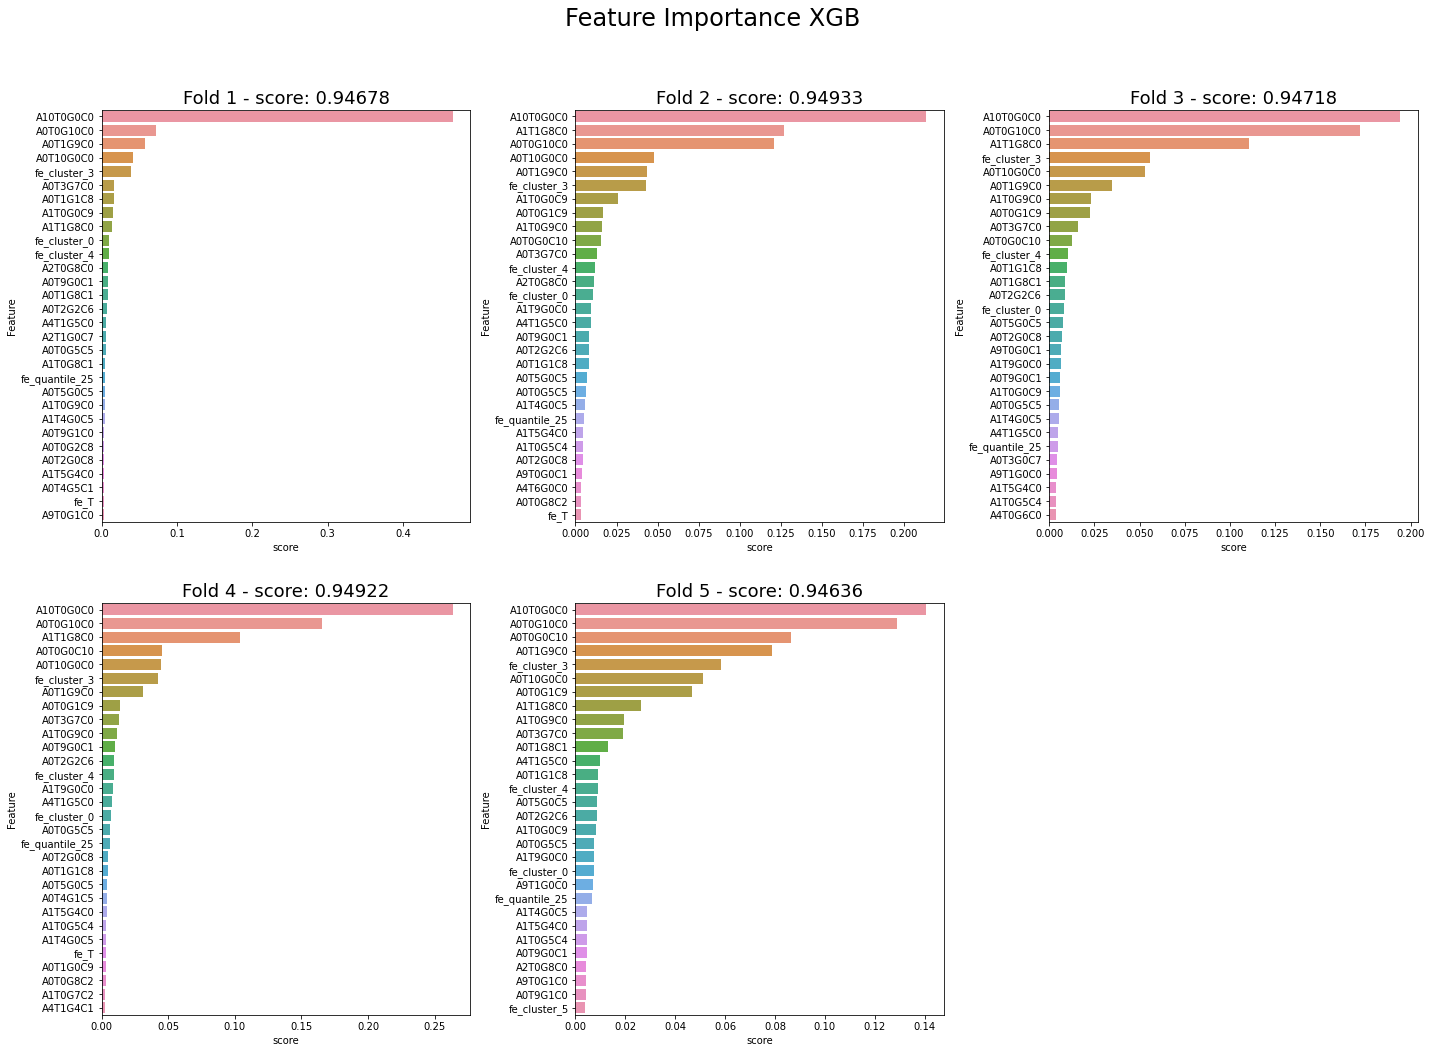

In [139]:
plt.figure(figsize=(20,20))
row = int(np.round(df_feature_imp.filter(regex=r'fold').shape[1] / 3 +1))
for fold, col in enumerate(df_feature_imp.filter(regex=r'fold').columns):            
    col_acc = 'acc_' + str(fold+1)
    df_fi = df_feature_imp.sort_values(by=col, ascending=False).reset_index().iloc[:30]
    df_fi = df_fi[['index', col, col_acc]]
    df_fi.columns = ['Feature', 'score', col_acc]
    plt.subplot(row,3, fold+1)
    sns.barplot(x='score', y='Feature', data=df_fi)    
    plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
              fontdict={'fontsize':18})    

plt.suptitle('Feature Importance XGB ', y=1.05, fontsize=24);
plt.tight_layout(h_pad=3.0); 

del df_fi

### 2.5.2. Predição

In [76]:
def predict_vies(model_, X_test_, scaler_):    
    vies              = np.array([0, 0, 0.03, 0.036, 0, 0, 0, 0, 0, 0])
    X_test_scaler     = pd.DataFrame(scaler_.transform(X_test_), columns=X_test_.columns)
    y_pred_test_proba = model_.predict_proba(X_test_scaler) + vies
    y_pred_test       = np.argmax(y_pred_test_proba, axis=1)
    return y_pred_test, y_pred_test_proba 

In [77]:
cols = X_valid.columns.to_list()
cols.remove('sample_weight')

In [78]:
%%time

lb     = LabelEncoder()
scaler = model[0]['scaler'] 
mdl    = model[0]['model']
y_lb   = lb.fit_transform(y_valid)

y_pred_val, y_pred_val_proba = predict_vies(mdl, X_valid[cols], scaler) 

acc = metrics.accuracy_score(y_lb, y_pred_val)

print('ACC: {:2.5f}'.format(acc))
print(metrics.classification_report(y_lb, y_pred_val, target_names=lb.classes_))

ACC: 0.96718
                          precision    recall  f1-score   support

    Bacteroides_fragilis       0.97      0.97      0.97      2505
    Campylobacter_jejuni       0.98      0.98      0.98      2494
      Enterococcus_hirae       0.97      0.97      0.97      2475
        Escherichia_coli       0.96      0.96      0.96      2459
  Escherichia_fergusonii       0.96      0.96      0.96      2457
   Klebsiella_pneumoniae       0.98      0.98      0.98      2484
     Salmonella_enterica       0.97      0.96      0.96      2478
   Staphylococcus_aureus       0.98      0.97      0.97      2483
Streptococcus_pneumoniae       0.96      0.96      0.96      2483
  Streptococcus_pyogenes       0.95      0.96      0.96      2481

                accuracy                           0.97     24799
               macro avg       0.97      0.97      0.97     24799
            weighted avg       0.97      0.97      0.97     24799

CPU times: user 2.24 s, sys: 7.99 ms, total: 2.25 s
Wall tim

### 2.5.3. Predição Teste e Submission

In [79]:
name_model     = name_model_clf + 'tunning_score_05_{:2.5f}_final.csv'.format(acc)
y_pred_test, _ = predict_vies(mdl, X_test[cols], scaler) 

df_submission[target] = lb.inverse_transform(y_pred_test)
df_submission.to_csv(path +'Data/submission/' + name_model, index=False)

<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>
    
</div>

# <div class="alert alert-success"> 3. FEATURE SELECTION </div>

## 3.1. Correção
Nesta primeira fase do processo vamos separar as melhores variáveis que tem  correlação significativa com o alvo (target), utilizando a correlação de Pearson.  

In [90]:
def p_value_warning_background(cell_value):
    highlight = 'background-color: lightcoral;'
    default = ''
    if cell_value > 0.05:
            return highlight
    return default

In [91]:
enc                        = OneHotEncoder(handle_unknown='ignore', sparse=False)
df_one_hot_encoder_targets = pd.DataFrame(enc.fit_transform(y))

df_one_hot_encoder_targets.columns = list(enc.categories_[0])
df_one_hot_encoder_targets.head()

,Bacteroides_fragilis,Campylobacter_jejuni,Enterococcus_hirae,Escherichia_coli,Escherichia_fergusonii,Klebsiella_pneumoniae,Salmonella_enterica,Staphylococcus_aureus,Streptococcus_pneumoniae,Streptococcus_pyogenes
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
%%time

p_values_target_list = []
cols = X.columns

for target_ in df_one_hot_encoder_targets.columns:
    p_values_list = []
    for c in cols:
        p = round(pearsonr(df_one_hot_encoder_targets.loc[:,target_], X.loc[:,c])[1], 4)
        p_values_list.append(p)       
    
    p_values_target_list.append(p_values_list)  

p_values_target_list = np.array(p_values_target_list)
p_values_target_list = p_values_target_list.reshape(len(cols), len(enc.categories_[0]))
df_p_values          = pd.DataFrame(p_values_target_list, columns=list(enc.categories_[0]), index=cols)

CPU times: user 23.2 s, sys: 44.5 s, total: 1min 7s
Wall time: 17.1 s


In [94]:
important_dict    = {}
feature_important = []

for index, col in enumerate(df_p_values.columns):
    cols_index = list(df_p_values.loc[df_p_values[col].values>0.05, col].index)
    important_dict[col] = cols_index
    for c in cols_index:
        feature_important.append(c)

feature_important.append('sample_weight')
feature_important_ignore_drop = list(np.unique(feature_important))

In [98]:
print('Temos {} variáveis significativas.'.format(len(feature_important_ignore_drop)), end='\n\n')
print('Variáveis: ', feature_important_ignore_drop)

Temos 142 variáveis significativas.

Variáveis:  ['A0T0G0C10', 'A0T0G10C0', 'A0T0G1C9', 'A0T0G4C6', 'A0T0G6C4', 'A0T0G8C2', 'A0T0G9C1', 'A0T1G1C8', 'A0T1G2C7', 'A0T1G4C5', 'A0T1G6C3', 'A0T1G9C0', 'A0T2G3C5', 'A0T2G5C3', 'A0T2G7C1', 'A0T2G8C0', 'A0T3G0C7', 'A0T3G1C6', 'A0T3G2C5', 'A0T3G6C1', 'A0T4G4C2', 'A0T4G5C1', 'A0T8G0C2', 'A0T8G1C1', 'A0T8G2C0', 'A0T9G1C0', 'A10T0G0C0', 'A1T0G0C9', 'A1T0G2C7', 'A1T0G6C3', 'A1T0G7C2', 'A1T1G1C7', 'A1T1G6C2', 'A1T1G8C0', 'A1T2G1C6', 'A1T2G7C0', 'A1T3G0C6', 'A1T3G1C5', 'A1T3G2C4', 'A1T3G3C3', 'A1T3G4C2', 'A1T3G5C1', 'A1T4G1C4', 'A1T4G2C3', 'A1T4G4C1', 'A1T5G2C2', 'A1T5G3C1', 'A1T5G4C0', 'A1T6G1C2', 'A1T8G0C1', 'A2T0G2C6', 'A2T0G3C5', 'A2T0G5C3', 'A2T0G6C2', 'A2T0G7C1', 'A2T1G1C6', 'A2T1G2C5', 'A2T1G3C4', 'A2T1G4C3', 'A2T1G5C2', 'A2T1G6C1', 'A2T2G0C6', 'A2T2G2C4', 'A2T2G3C3', 'A2T2G6C0', 'A2T3G5C0', 'A2T4G4C0', 'A2T5G0C3', 'A2T5G2C1', 'A2T5G3C0', 'A2T6G2C0', 'A2T7G0C1', 'A2T8G0C0', 'A3T0G2C5', 'A3T0G7C0', 'A3T1G3C3', 'A3T1G4C2', 'A3T1G5C1', 'A3T2G0C5',

## 3.2. Boruta

In [283]:
%%time 

sc = RobustScaler()
lb = LabelEncoder()

X_scaler = X.drop(['sample_weight'], axis=1)
X_scaler = pd.DataFrame(sc.fit_transform(X_scaler), columns=X_scaler.columns)
y_label  = pd.DataFrame(lb.fit_transform(y), columns=[target])

X_scaler.shape

(123993, 316)

In [ ]:
model = xgb.XGBClassifier(**params_best)

feat_selector = BorutaPy(model, 
                         n_estimators = 'auto', 
                         two_step     = False,
                         verbose      = 2, 
                         max_iter     = 100,
                         random_state = 42)

feat_selector.fit(X_scaler.values, y_label.values)

In [ ]:
X_train_selected = X_scaler.iloc[:,feat_selector.support_]
X_test_selected  = X_test.iloc[:,feat_selector.support_]

X_train_selected['sample_weight'] = X['sample_weight']
X_test_selected.shape , X_test_selected.shape

### 3.2.1. Feature 

- Variáveis selecionadas

In [110]:
#feature_selected_boruta = ['A0T0G0C10', 'A0T0G1C9', 'A0T0G2C8', 'A0T0G3C7', 'A0T0G4C6', 'A0T0G5C5', 'A0T0G6C4', 'A0T0G7C3', 'A0T0G8C2', 'A0T0G10C0', 'A0T1G0C9', 'A0T1G1C8', 'A0T1G2C7', 'A0T1G3C6', 'A0T1G4C5', 'A0T1G5C4', 'A0T1G6C3', 'A0T1G8C1', 'A0T1G9C0', 'A0T2G0C8', 'A0T2G1C7', 'A0T2G2C6', 'A0T2G3C5', 'A0T2G4C4', 'A0T2G5C3', 'A0T2G6C2', 'A0T2G7C1', 'A0T2G8C0', 'A0T3G0C7', 'A0T3G1C6', 'A0T3G2C5', 'A0T3G3C4', 'A0T3G4C3', 'A0T3G5C2', 'A0T3G6C1', 'A0T3G7C0', 'A0T4G0C6', 'A0T4G1C5', 'A0T4G2C4', 'A0T4G3C3', 'A0T4G4C2', 'A0T4G5C1', 'A0T4G6C0', 'A0T5G0C5', 'A0T5G1C4', 'A0T5G2C3', 'A0T5G3C2', 'A0T5G4C1', 'A0T5G5C0', 'A0T6G0C4', 'A0T6G1C3', 'A0T6G2C2', 'A0T6G3C1', 'A0T6G4C0', 'A0T7G0C3', 'A0T7G1C2', 'A0T7G2C1', 'A0T7G3C0', 'A0T8G0C2', 'A0T8G1C1', 'A0T8G2C0', 'A0T9G0C1', 'A0T9G1C0', 'A0T10G0C0', 'A1T0G1C8', 'A1T0G2C7', 'A1T0G3C6', 'A1T0G4C5', 'A1T0G5C4', 'A1T0G6C3', 'A1T0G7C2', 'A1T0G8C1', 'A1T0G9C0', 'A1T1G0C8', 'A1T1G1C7', 'A1T1G2C6', 'A1T1G3C5', 'A1T1G4C4', 'A1T1G5C3', 'A1T1G6C2', 'A1T1G7C1', 'A1T1G8C0', 'A1T2G0C7', 'A1T2G1C6', 'A1T2G2C5', 'A1T2G3C4', 'A1T2G4C3', 'A1T2G5C2', 'A1T2G6C1', 'A1T2G7C0', 'A1T3G0C6', 'A1T3G1C5', 'A1T3G2C4', 'A1T3G3C3', 'A1T3G4C2', 'A1T3G5C1', 'A1T3G6C0', 'A1T4G0C5', 'A1T4G1C4', 'A1T4G2C3', 'A1T4G3C2', 'A1T4G4C1', 'A1T4G5C0', 'A1T5G0C4', 'A1T5G1C3', 'A1T5G2C2', 'A1T5G3C1', 'A1T5G4C0', 'A1T6G0C3', 'A1T6G1C2', 'A1T6G2C1', 'A1T6G3C0', 'A1T7G0C2', 'A1T7G1C1', 'A1T7G2C0', 'A1T8G0C1', 'A1T8G1C0', 'A1T9G0C0', 'A2T0G0C8', 'A2T0G1C7', 'A2T0G2C6', 'A2T0G3C5', 'A2T0G4C4', 'A2T0G5C3', 'A2T0G6C2', 'A2T0G7C1', 'A2T0G8C0', 'A2T1G0C7', 'A2T1G1C6', 'A2T1G2C5', 'A2T1G3C4', 'A2T1G4C3', 'A2T1G5C2', 'A2T1G6C1', 'A2T1G7C0', 'A2T2G0C6', 'A2T2G1C5', 'A2T2G2C4', 'A2T2G3C3', 'A2T2G4C2', 'A2T2G5C1', 'A2T2G6C0', 'A2T3G0C5', 'A2T3G1C4', 'A2T3G2C3', 'A2T3G3C2', 'A2T3G4C1', 'A2T3G5C0', 'A2T4G0C4', 'A2T4G1C3', 'A2T4G2C2', 'A2T4G3C1', 'A2T4G4C0', 'A2T5G0C3', 'A2T5G1C2', 'A2T5G2C1', 'A2T5G3C0', 'A2T6G0C2', 'A2T6G1C1', 'A2T6G2C0', 'A2T7G0C1', 'A2T7G1C0', 'A2T8G0C0', 'A3T0G0C7', 'A3T0G1C6', 'A3T0G2C5', 'A3T0G3C4', 'A3T0G4C3', 'A3T0G5C2', 'A3T0G6C1', 'A3T0G7C0', 'A3T1G0C6', 'A3T1G1C5', 'A3T1G2C4', 'A3T1G3C3', 'A3T1G4C2', 'A3T1G5C1', 'A3T1G6C0', 'A3T2G0C5', 'A3T2G1C4', 'A3T2G2C3', 'A3T2G3C2', 'A3T2G4C1', 'A3T2G5C0', 'A3T3G0C4', 'A3T3G1C3', 'A3T3G2C2', 'A3T3G3C1', 'A3T3G4C0', 'A3T4G0C3', 'A3T4G1C2', 'A3T4G2C1', 'A3T4G3C0', 'A3T5G0C2', 'A3T5G1C1', 'A3T5G2C0', 'A3T6G0C1', 'A3T6G1C0', 'A3T7G0C0', 'A4T0G0C6', 'A4T0G1C5', 'A4T0G2C4', 'A4T0G3C3', 'A4T0G4C2', 'A4T0G5C1', 'A4T0G6C0', 'A4T1G0C5', 'A4T1G1C4', 'A4T1G2C3', 'A4T1G3C2', 'A4T1G4C1', 'A4T1G5C0', 'A4T2G0C4', 'A4T2G1C3', 'A4T2G2C2', 'A4T2G3C1', 'A4T2G4C0', 'A4T3G0C3', 'A4T3G1C2', 'A4T3G2C1', 'A4T3G3C0', 'A4T4G0C2', 'A4T4G1C1', 'A4T4G2C0', 'A4T5G0C1', 'A4T5G1C0', 'A4T6G0C0', 'A5T0G0C5', 'A5T0G1C4', 'A5T0G2C3', 'A5T0G3C2', 'A5T0G4C1', 'A5T0G5C0', 'A5T1G0C4', 'A5T1G1C3', 'A5T1G2C2', 'A5T1G3C1', 'A5T1G4C0', 'A5T2G0C3', 'A5T2G1C2', 'A5T2G3C0', 'A5T3G0C2', 'A5T3G1C1', 'A5T3G2C0', 'A5T4G0C1', 'A5T4G1C0', 'A5T5G0C0', 'A6T0G0C4', 'A6T0G1C3', 'A6T0G2C2', 'A6T0G3C1', 'A6T0G4C0', 'A6T1G0C3', 'A6T1G1C2', 'A6T1G2C1', 'A6T1G3C0', 'A6T2G0C2', 'A6T2G1C1', 'A6T2G2C0', 'A6T3G0C1', 'A6T3G1C0', 'A6T4G0C0', 'A7T0G0C3', 'A7T0G1C2', 'A7T0G2C1', 'A7T0G3C0', 'A7T1G0C2', 'A7T1G1C1', 'A7T1G2C0', 'A7T2G0C1', 'A7T2G1C0', 'A7T3G0C0', 'A8T0G0C2', 'A8T0G1C1', 'A8T0G2C0', 'A8T1G0C1', 'A8T1G1C0', 'A8T2G0C0', 'A9T0G0C1', 'A9T0G1C0', 'A9T1G0C0', 'A10T0G0C0', 'fe_median', 'fe_min', 'fe_quantile_25', 'fe_quantile_50', 'fe_quantile_75', 'fe_iqr', 'fe_dispersion_1', 'fe_A', 'fe_T', 'fe_G', 'fe_C', 'fe_pca_0', 'fe_pca_1', 'fe_pca_2', 'fe_pca_3', 'fe_cluster_0', 'fe_cluster_1', 'fe_cluster_2', 'fe_cluster_3', 'fe_cluster_4', 'fe_cluster_5', 'sample_weight']

In [111]:
feature_selected_boruta = X_train_selected.columns.to_list()
print(feature_selected_boruta)

['A0T0G0C10', 'A0T0G1C9', 'A0T0G2C8', 'A0T0G3C7', 'A0T0G4C6', 'A0T0G5C5', 'A0T0G6C4', 'A0T0G7C3', 'A0T0G8C2', 'A0T0G10C0', 'A0T1G0C9', 'A0T1G1C8', 'A0T1G2C7', 'A0T1G3C6', 'A0T1G4C5', 'A0T1G5C4', 'A0T1G6C3', 'A0T1G8C1', 'A0T1G9C0', 'A0T2G0C8', 'A0T2G1C7', 'A0T2G2C6', 'A0T2G3C5', 'A0T2G4C4', 'A0T2G5C3', 'A0T2G6C2', 'A0T2G7C1', 'A0T2G8C0', 'A0T3G0C7', 'A0T3G1C6', 'A0T3G2C5', 'A0T3G3C4', 'A0T3G4C3', 'A0T3G5C2', 'A0T3G6C1', 'A0T3G7C0', 'A0T4G0C6', 'A0T4G1C5', 'A0T4G2C4', 'A0T4G3C3', 'A0T4G4C2', 'A0T4G5C1', 'A0T4G6C0', 'A0T5G0C5', 'A0T5G1C4', 'A0T5G2C3', 'A0T5G3C2', 'A0T5G4C1', 'A0T5G5C0', 'A0T6G0C4', 'A0T6G1C3', 'A0T6G2C2', 'A0T6G3C1', 'A0T6G4C0', 'A0T7G0C3', 'A0T7G1C2', 'A0T7G2C1', 'A0T7G3C0', 'A0T8G0C2', 'A0T8G1C1', 'A0T8G2C0', 'A0T9G0C1', 'A0T9G1C0', 'A0T10G0C0', 'A1T0G1C8', 'A1T0G2C7', 'A1T0G3C6', 'A1T0G4C5', 'A1T0G5C4', 'A1T0G6C3', 'A1T0G7C2', 'A1T0G8C1', 'A1T0G9C0', 'A1T1G0C8', 'A1T1G1C7', 'A1T1G2C6', 'A1T1G3C5', 'A1T1G4C4', 'A1T1G5C3', 'A1T1G6C2', 'A1T1G7C1', 'A1T1G8C0', 'A1T2G0C7', 

- Variáveis ignoradas

In [112]:
feature_rejected = [col for col in X.columns if col not in feature_selected_boruta]
print(feature_rejected)

['A0T0G9C1', 'A0T1G7C2', 'A1T0G0C9', 'A5T2G2C1', 'fe_mean', 'fe_std', 'fe_var', 'fe_max', 'fe_skew', 'fe_kurt', 'fe_range', 'fe_tails', 'fe_gcd']


## 3.3. Feature autocorrelaciondas

In [113]:
threshold = .75

print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold))
df = X[feature_selected_boruta].corr(method ='pearson').round(5)
df_corr = df[abs(df)>threshold][df!=1.0].unstack().dropna().reset_index()
df_corr.columns =  ['var_1', 'var_2', 'corr']
#df_corr.head(100)

Variáveis autocorrelacionadas threshold=0.75


In [105]:
feature_aut_corr = list(df_corr['var_1'].unique())
print('Temos {} variáveis autocorrelaciodas.'.format(len(feature_aut_corr)))

Temos 50 variáveis autocorrelaciodas.


- Vamos remover as variáveis autocorrelacionadas. 

In [124]:
#cols_feature_selected = [col for col in cols_feature_selected_boruta if col not in feature_aut_corr]
#print('Temos agora {} variáveis.'.format(len(cols_feature_selected)), end='\n\n')
#print(cols_feature_selected)
len(feature_aut_corr)

50

In [125]:
for col in [col for col in feature_important_ignore_drop if col in feature_aut_corr]:
    feature_aut_corr.remove(col)

len(feature_aut_corr) 

29

In [127]:
len(feature_selected_boruta)

304

In [130]:
for col in [col for col in feature_aut_corr if col in feature_selected_boruta]:
    feature_selected_boruta.remove(col)
    
len(feature_selected_boruta)

275

In [134]:
for col in [col for col in feature_important_ignore_drop if col not in feature_selected_boruta]:
    feature_selected_boruta.append(col)

In [154]:
threshold = .75

print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold))
df = X[feature_selected_boruta].corr(method ='pearson').round(5)
df_corr = df[abs(df)>threshold][df!=1.0].unstack().dropna().reset_index()
df_corr.columns =  ['var_1', 'var_2', 'corr']
df_corr

Variáveis autocorrelacionadas threshold=0.75


,var_1,var_2,corr
0,A1T2G7C0,fe_cluster_1,0.94481
1,A1T3G3C3,fe_C,0.80575
2,A2T1G2C5,fe_C,0.79174
3,A2T1G3C4,fe_T,-0.75994
4,A2T1G3C4,fe_C,0.85294
5,A2T1G4C3,fe_T,-0.82968
6,A2T1G4C3,fe_C,0.85294
7,A2T1G5C2,fe_C,0.77902
8,A2T2G3C3,fe_T,-0.76725
9,A2T2G3C3,fe_C,0.85976


In [166]:
for col in [col for col in feature_selected_boruta if col in df_corr['var_1'].values]:
    feature_selected_boruta.append(col)

## 3.3. Modelagem
Vamos fazer dois modelos, um com as variáveis selecionadas com o boruta e outro sem as variáveis autocorrelacionadas. 

In [182]:
feature_selected_boruta    = list(np.unique(feature_selected_boruta))
feature_selected_boruta_tr = feature_selected_boruta.copy()
feature_selected_boruta_ts = feature_selected_boruta_tr.copy() 

feature_selected_boruta_ts.remove('sample_weight')

len(feature_selected_boruta_tr), len(feature_selected_boruta_ts)

(279, 278)

In [183]:
%%time

list_feature_imp = []    
name_model       = name_model_clf + 'tunning_boruta_score_06'
    
model, score, df_feature_imp , df_preds_prob, y_pred_test = \
TunningModels.train_model_cv(model_            = xgb.XGBClassifier(**params_best), 
                                X_             = X[feature_selected_boruta_tr], 
                                y_             = y, 
                                X_test_        = X_test[feature_selected_boruta_ts], 
                                target_        = target, 
                                model_name_    = name_model, 
                                sc_            = RobustScaler(), 
                                sc_second_     = None, 
                                n_splits_      = 5, 
                                seed_          = SEED,
                                path_          = path, 
                                save_predict_  = True, 
                                level_         = '1', 
                                print_result_  = True, 
                                feature_       = None, 
                                trial_         = None)

list_feature_imp.append(df_feature_imp)

XGBClassifier - n_estimators: 1450 seed: 12359  
[Fold 1] ACC: 0.94503 -  0h 2m 55s
[Fold 2] ACC: 0.94836 -  0h 3m 14s
[Fold 3] ACC: 0.94678 -  0h 2m 53s
[Fold 4] ACC: 0.94922 -  0h 2m 45s
[Fold 5] ACC: 0.94608 -  0h 2m 50s
----------------------------------------------------
[Mean Fold] ACC: 0.94709 std: 0.00152 - 0h 14m 47s

CPU times: user 14min 48s, sys: 2.81 s, total: 14min 51s
Wall time: 14min 48s


<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>
Aqui temos um ponto interessante, o primeiro modelo tem melhor score, mas também com mais variáveis se tornando mais complexo e com mais ruidos, sendo assim, o segundo modelo me parece mais estável e a diferença é relativamente pequena, a partir desse ponto vamos utilizar apenas as variáveis do segundo modelo na geração dos próximos modelos.           

- Primeiro modelo 0,93936
- Segundo modelo 


Vamos dar uma olhada nas importância das variáveis. 

</div>

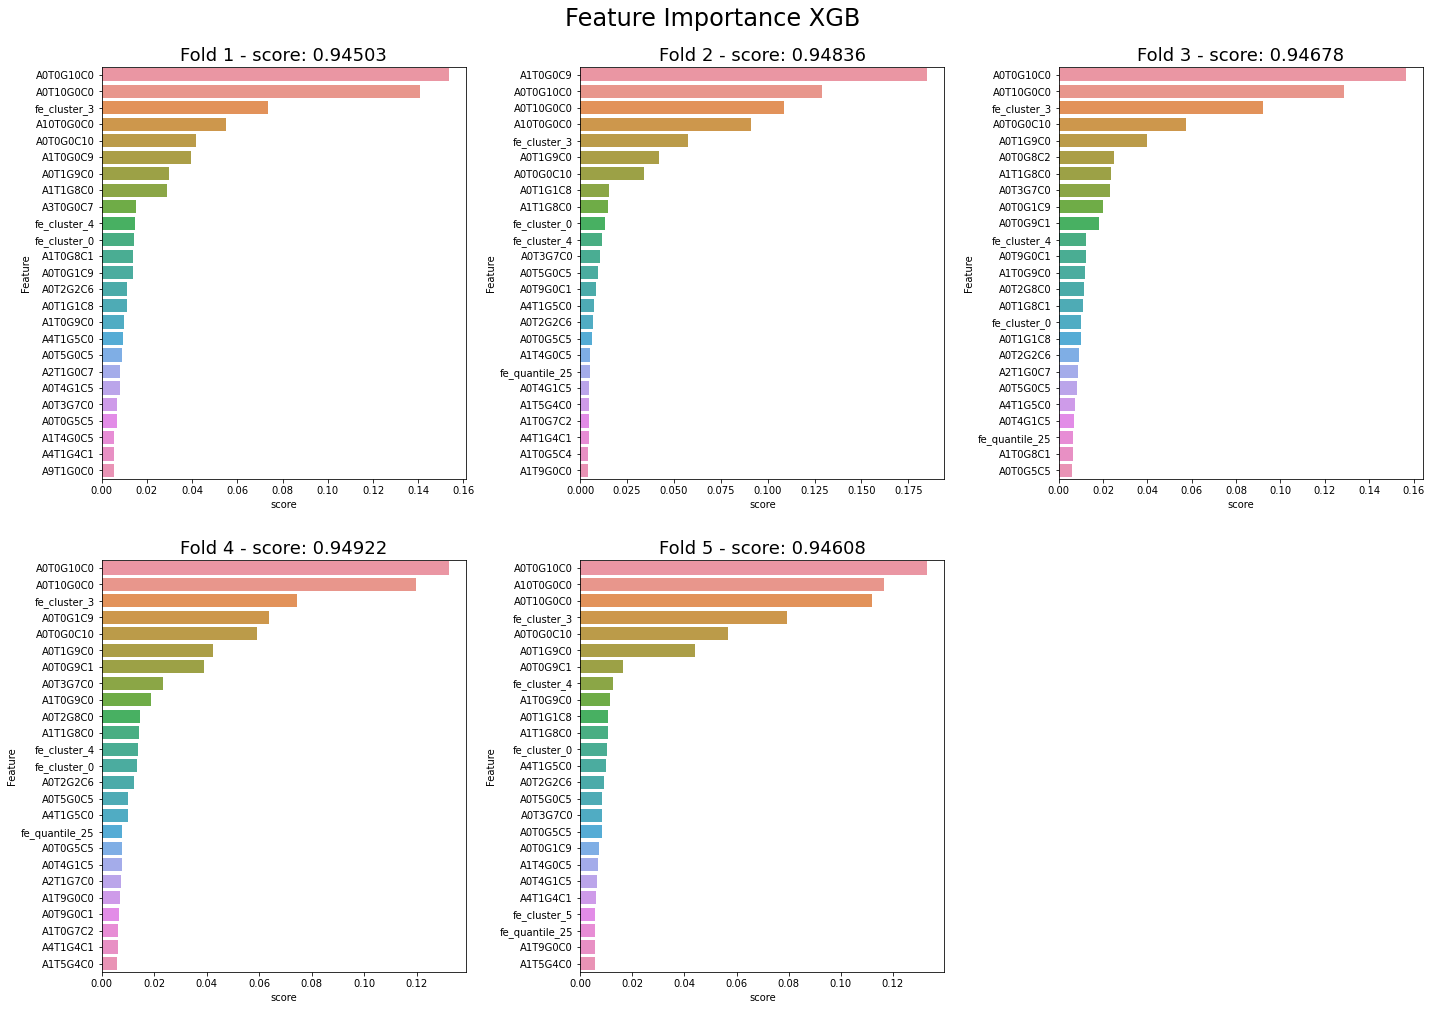

In [184]:
for i in range(len(list_feature_imp)):
    plt.figure(figsize=(20,20))
    row = int(np.round(list_feature_imp[0].filter(regex=r'fold').shape[1] / 3 +1))
    for fold, col in enumerate(list_feature_imp[0].filter(regex=r'fold').columns):            
        col_acc = 'acc_' + str(fold+1)
        df_fi = list_feature_imp[0].sort_values(by=col, ascending=False).reset_index().iloc[:25]
        df_fi = df_fi[['index', col, col_acc]]
        df_fi.columns = ['Feature', 'score', col_acc]
        plt.subplot(row,3, fold+1)
        sns.barplot(x='score', y='Feature', data=df_fi)    
        plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
                  fontdict={'fontsize':18})    

    plt.suptitle('Feature Importance XGB ', y=1.02, fontsize=24);
    plt.tight_layout(h_pad=3.0); 

del df_fi

# <div class="alert alert-success"> 3. DIVERCIDADE </div>

Nesta etapa vamos utilizar os melhores parametros, que encontramos na tunagem, para gerar diversos modelos com divercidade.

## 3.1. Seed 

In [185]:
%%time 

SEED_      = [42, 59, 1000, 1500, 2020, 2021]
df_seed    = pd.DataFrame()
score_best = 0 
seed_best  = 0 

TunningModels.delete_files(name_model)

for i, seed_ in  enumerate (SEED_):     
    name_model = name_model_clf + 'seed_'+ str(i+1) +'_score_07'
        
    model, score, df_feature_imp , df_preds_prob, y_pred_test = \
    TunningModels.train_model_cv(model_         = xgb.XGBClassifier(**params_best), 
                                 X_             = X[feature_selected_boruta_tr], 
                                 y_             = y,
                                 X_test_        = X_test[feature_selected_boruta_ts], 
                                 target_        = target, 
                                 model_name_    = name_model, 
                                 sc_            = RobustScaler(), 
                                 sc_second_     = None, 
                                 n_splits_      = 5, 
                                 seed_          = seed_,
                                 path_          = path, 
                                 save_predict_  = True, 
                                 level_         = '1', 
                                 print_result_  = True, 
                                 feature_       = None, 
                                 trial_         = None)
    
    if score > score_best:
        seed_best  = seed_  
        score_best = score
    
    df_seed['seed_' + str(seed_)] = y_pred_test 
    
print()
print('Seed : {}'.format(seed_best))
print('Score: {}'.format(score_best))
print()

XGBClassifier - n_estimators: 1450 seed: 42  
[Fold 1] ACC: 0.94727 -  0h 2m 57s
[Fold 2] ACC: 0.94601 -  0h 2m 43s
[Fold 3] ACC: 0.95178 -  0h 3m 5s
[Fold 4] ACC: 0.94912 -  0h 3m 12s
[Fold 5] ACC: 0.94905 -  0h 2m 39s
----------------------------------------------------
[Mean Fold] ACC: 0.94865 std: 0.00195 - 0h 14m 47s

XGBClassifier - n_estimators: 1450 seed: 59  
[Fold 1] ACC: 0.95015 -  0h 3m 5s
[Fold 2] ACC: 0.94461 -  0h 2m 50s
[Fold 3] ACC: 0.94538 -  0h 3m 1s
[Fold 4] ACC: 0.94789 -  0h 2m 37s
[Fold 5] ACC: 0.94887 -  0h 2m 50s
----------------------------------------------------
[Mean Fold] ACC: 0.94738 std: 0.00209 - 0h 14m 34s

XGBClassifier - n_estimators: 1450 seed: 1000  
[Fold 1] ACC: 0.94508 -  0h 2m 44s
[Fold 2] ACC: 0.95038 -  0h 2m 58s
[Fold 3] ACC: 0.94836 -  0h 2m 56s
[Fold 4] ACC: 0.94936 -  0h 2m 59s
[Fold 5] ACC: 0.94569 -  0h 2m 51s
----------------------------------------------------
[Mean Fold] ACC: 0.94778 std: 0.00206 - 0h 14m 38s

XGBClassifier - n_estim

In [186]:
df_seed.head()

,seed_42,seed_59,seed_1000,seed_1500,seed_2020,seed_2021
0,4,4,4,4,4,4
1,6,6,6,6,6,6
2,2,2,2,2,2,2
3,6,6,6,6,6,6
4,7,7,7,7,7,7


### 3.1.1. Gerar submission 

In [187]:
lb = LabelEncoder()
lb.fit_transform(y)

y_pred_test = df_seed.mode(axis=1)[0]
y_pred_test = lb.inverse_transform(y_pred_test.astype(int))

name_model = name_model_clf + 'stacking_01_seed.csv'.format(score_best)

df_submission[target] = y_pred_test
df_submission.to_csv(path +'Data/submission/' + name_model, index=False)

## 3.2. Leaning Rate

In [ ]:
%%time 

learning_rate      = [0.1, 0.01, 0.005, 0.007]
df_learning_rate   = pd.DataFrame()
df_leaning_rate    = pd.DataFrame()
params_l_rate      = params_best.copy()
score_best         = 0 
learning_rate_best = 0 

TunningModels.delete_files(name_model)

for i, learning_rate_ in  enumerate (learning_rate):   
    name_model         = name_model_clf + 'leanig_rate_'+ str(i+1) +'_score_08'
    params_l_rate['learning_rate'] = learning_rate_     
    model, score, df_feature_imp , df_preds_prob, y_pred_test = \
    TunningModels.train_model_cv(model_         = xgb.XGBClassifier(**params_l_rate), 
                                 X_             = X[feature_selected_boruta_tr], 
                                 y_             = y, 
                                 X_test_        = X_test[feature_selected_boruta_ts], 
                                 target_        = target, 
                                 model_name_    = name_model, 
                                 sc_            = RobustScaler(), 
                                 sc_second_     = None, 
                                 n_splits_      = 5, 
                                 seed_          = seed_best,
                                 path_          = path, 
                                 save_predict_  = True, 
                                 level_         = '1', 
                                 print_result_  = True, 
                                 feature_       = None, 
                                 trial_         = None)
    
    if score > score_best:
        learning_rate_best  = learning_rate_  
        score_best          = score
    
    df_leaning_rate['leaning_rate_' + str(learning_rate_)] = y_pred_test 

print()
print('Leaning Rate : {}'.format(learning_rate_best))
print('Score        : {}'.format(score_best))
print()

XGBClassifier - n_estimators: 1450 seed: 42  
[Fold 1] ACC: 0.94949 -  0h 3m 17s
[Fold 2] ACC: 0.94751 -  0h 3m 8s
[Fold 3] ACC: 0.95064 -  0h 3m 23s
[Fold 4] ACC: 0.94761 -  0h 3m 8s
[Fold 5] ACC: 0.94702 -  0h 3m 1s
----------------------------------------------------
[Mean Fold] ACC: 0.94845 std: 0.00138 - 0h 16m 9s

XGBClassifier - n_estimators: 1450 seed: 42  
[Fold 1] ACC: 0.92326 -  0h 3m 50s
[Fold 2] ACC: 0.92554 -  0h 3m 51s
[Fold 3] ACC: 0.92636 -  0h 3m 51s
[Fold 4] ACC: 0.92463 -  0h 3m 46s
[Fold 5] ACC: 0.92685 -  0h 3m 54s
----------------------------------------------------
[Mean Fold] ACC: 0.92533 std: 0.00128 - 0h 19m 30s

XGBClassifier - n_estimators: 1450 seed: 42  
[Fold 1] ACC: 0.88892 -  0h 3m 53s
[Fold 2] ACC: 0.89509 -  0h 3m 53s
[Fold 3] ACC: 0.89338 -  0h 3m 52s
[Fold 4] ACC: 0.89270 -  0h 3m 49s
[Fold 5] ACC: 0.89411 -  0h 3m 56s
----------------------------------------------------
[Mean Fold] ACC: 0.89284 std: 0.00211 - 0h 19m 42s

XGBClassifier - n_estimato

In [ ]:
df_leaning_rate.head()

### 3.2.1. Gerar submission 

In [ ]:
lb = LabelEncoder()
lb.fit_transform(y)

y_pred_test = df_leaning_rate.mode(axis=1)[0]
y_pred_test = lb.inverse_transform(y_pred_test.astype(int))

name_model = name_model_clf + 'stacking_02_leaning_rate.csv'.format(score_best)

df_submission[target] = y_pred_test
df_submission.to_csv(path +'Data/submission/' + name_model, index=False)

## 3.3. Max Depth

In [ ]:
%%time 

max_dep        = [1, 3, 13, 15, 19]
df_max_depth   = pd.DataFrame()
params_max_dep = params_best.copy()
score_best     = 0 
max_dep_best   = 0 

TunningModels.delete_files(name_model)

for i, max_dep_ in  enumerate (max_dep):    
    name_model = name_model_clf + 'max_dep_'+ str(i+1) + '_score_09'
    params_max_dep['max_depth'] = max_dep_     
    
    model, score, df_feature_imp , df_preds_prob, y_pred_test = \
    TunningModels.train_model_cv(model_         = xgb.XGBClassifier(**params_max_dep), 
                                 X_             = X[feature_selected_boruta_tr], 
                                 y_             = y, 
                                 X_test_        = X_test[feature_selected_boruta_ts], 
                                 target_        = target, 
                                 model_name_    = name_model, 
                                 sc_            = RobustScaler(), 
                                 sc_second_     = None, 
                                 n_splits_      = 5, 
                                 seed_          = seed_best,
                                 path_          = path, 
                                 save_predict_  = True, 
                                 level_         = '1', 
                                 print_result_  = True, 
                                 feature_       = None, 
                                 trial_         = None)
    
    if score > score_best:
        max_dep_best  = max_dep_  
        score_best    = score
    
    df_max_depth['max_depth_' + str(max_dep_)] = y_pred_test 

print()
print('Max Depth: {}'.format(max_dep_best))
print('Score    : {}'.format(score_best))
print()

In [ ]:
df_max_depth.head()

### 3.3.1. Gerar submission 

In [ ]:
lb = LabelEncoder()
lb.fit_transform(y)

y_pred_test = df_max_depth.mode(axis=1)[0]
y_pred_test = lb.inverse_transform(y_pred_test.astype(int))

name_model = name_model_clf + 'stacking_03_max_depth.csv'.format(score_best)

df_submission[target] = y_pred_test
df_submission.to_csv(path +'Data/submission/' + name_model, index=False)

## 3.4. Feature

In [ ]:
%%time

name_model = name_model_clf + '_div_feature_10_'

TunningModels.model_of_diversity_feature_group(model_     = xgb.XGBClassifier(**params_best), 
                                               name_model = name_model, 
                                               X_         = X[feature_selected_boruta_tr], 
                                               y_         = y, 
                                               X_ts_      = X_test[feature_selected_boruta_ts],
                                               target_    = target,
                                               sc_        = RobustScaler(),
                                               seed_      = seed_best)  

# <div class="alert alert-success"> 4. ENSEMBLE </div>

## 4.1. Recuparar dataset
Vamos recuperar todas as previsões do XGBoost para gerar um ensable. 

In [ ]:
%%time 
df_train_xgb, df_test_xgb = TunningModels.df_return_preds_tunning('xgb', 
                                                                  train_shape_row = X.shape[0],
                                                                  test_shape_row  = X_test.shape[0])
print(df_train_xgb.shape, df_test_xgb.shape)
print()

In [ ]:
df_train_xgb.head()

In [ ]:
jb.dump(df_train_xgb, 'Data/pkl/df_nb_03_train_xgb.pkl.z')
jb.dump(df_test_xgb,  'Data/pkl/df_nb_03_test_xgb.pkl.z')